In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [3]:
# Correct URLs for the raw CSV files
df_url = 'https://raw.githubusercontent.com/mredshaw/AI_BUS/main/train.csv'
df_test_url = 'https://raw.githubusercontent.com/mredshaw/AI_BUS/main/test.csv'

# Reading the CSV files
df = pd.read_csv(df_url, delimiter=',')
df_test = pd.read_csv(df_test_url, delimiter=',')


Let's first compare the two datasets to ensure there is consistency between them and determine what cleaning we need to do.

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Both datasets are missing well over 10% of the Cabin data, so I will drop this column. For the Age column, this data will likely be important so I want to keep the column. I will fill the missing volues with the mean age based on the Sex of the person. I will fill the missing Embarked values with the mode, and the missing Fare amounts with the mean per corresponding Pclass.

In [8]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [9]:
def clean_data(df):
    df = df.drop(['Cabin', 'Ticket'], axis=1)
    df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
                
    return df

There are a few additional columns I want to make as well. First, the name columns tend to have some titles associated with them which could provide info on the perceived importance or social rank of a person, which could impact their survival rate. I want to extract that title and set it as a new value in the dataframe.

In [10]:
def create_title_column(df):
    df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()
    title_counts = df['Title'].value_counts()
    rare_title = title_counts[title_counts < 10].index
    df['Title'] = df['Title'].replace(rare_title, 'Other')
    df = df.drop(['Name'], axis=1)
    
    return df


To make information a little more generalized, I want to bin some information such as age and fare amount. I noticed that certain age ranges have higher survival rates than others, so I want to try and bin these in a way that groups people into a bin with others who have similar survival rates. For fares, I'll bin based on 3 levels of high medium and low.

In [11]:
def create_bins(df):
    bin_range = [0, 5, 10, 15, 30, 40, 50, 60, 70, 80]  
    labels = range(1, len(bin_range))
    df['Age_Bin'] = pd.cut(df['Age'], bins=bin_range, labels=labels).astype(int)
    df['Fare_Bin'] = pd.qcut(df['Fare'], q=3, labels=[1, 2, 3]).astype(int)

    return df

I also want a numerical representation of some of our categorical string variables. I will set those here:

In [12]:
def encode_categorical_variables(df):
    label_encoder = LabelEncoder()
    df['Embarked_Code'] = label_encoder.fit_transform(df['Embarked'])
    df['Sex_Code'] = label_encoder.fit_transform(df['Sex'])
    df['Title_Code'] = label_encoder.fit_transform(df['Title'])
    
    return df


Now let's run our dataframes through these cleaning and pre-processing functions we defined above.

In [13]:
df = clean_data(df)
df = create_title_column(df)
df = create_bins(df)
df = encode_categorical_variables(df)

In [14]:
df_test = clean_data(df_test)
df_test = create_title_column(df_test)
df_test = create_bins(df_test)
df_test = encode_categorical_variables(df_test)

Let's check to make sure the cleaning was done properly on both sets.

In [15]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,NaN,646,517,NaN,NaN,NaN,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,29.736034,0.523008,0.381594,32.204208,NaN,NaN,4.537598,1.985410,1.536476,0.647587,1.906846
std,257.353842,0.486592,0.836071,NaN,13.014897,1.102743,0.806057,49.693429,NaN,NaN,1.355592,0.822991,0.791503,0.477990,0.798361
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,22.000000,0.000000,0.000000,7.910400,NaN,NaN,4.000000,1.000000,1.000000,0.000000,2.000000
50%,446.000000,0.000000,3.000000,NaN,30.000000,0.000000,0.000000,14.454200,NaN,NaN,4.000000,2.000000,2.000000,1.000000,2.000000
75%,668.500000,1.000000,3.000000,NaN,35.000000,1.000000,0.000000,31.000000,NaN,NaN,5.000000,3.000000,2.000000,1.000000,2.000000


In [16]:
df_test.describe(include='all')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
count,418.000000,418.000000,418,418.000000,418.000000,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418.000000,418.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,5,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Mr,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,266,NaN,NaN,NaN,NaN,270,240,NaN,NaN,NaN,NaN,NaN
mean,1100.500000,2.265550,NaN,30.272597,0.447368,0.392344,35.571764,NaN,NaN,4.650718,1.964115,1.401914,0.636364,1.918660
std,120.810458,0.841838,NaN,12.634534,0.896760,0.981429,55.851997,NaN,NaN,1.268513,0.814234,0.854496,0.481622,0.788458
min,892.000000,1.000000,NaN,0.170000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,23.000000,0.000000,0.000000,7.895800,NaN,NaN,4.000000,1.000000,1.000000,0.000000,2.000000
50%,1100.500000,3.000000,NaN,30.272362,0.000000,0.000000,14.454200,NaN,NaN,5.000000,2.000000,2.000000,1.000000,2.000000
75%,1204.750000,3.000000,NaN,35.750000,1.000000,0.000000,31.471875,NaN,NaN,5.000000,3.000000,2.000000,1.000000,2.000000


In [17]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,4,1,2,1,2
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,5,3,0,0,3
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,4,1,2,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,5,3,2,0,3
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,5,1,2,1,2


In [18]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code
0,892,3,male,34.5,0,0,7.8292,Q,Mr,5,1,1,1,2
1,893,3,female,47.0,1,0,7.0000,S,Mrs,6,1,2,0,3
2,894,2,male,62.0,0,0,9.6875,Q,Mr,8,2,1,1,2
3,895,3,male,27.0,0,0,8.6625,S,Mr,4,1,2,1,2
4,896,3,female,22.0,1,1,12.2875,S,Mrs,4,2,2,0,3


I want to visualize the data distribution of both datasets to check what kind of distribution the data has, but also check to see if both datasets are similar in their distribution.

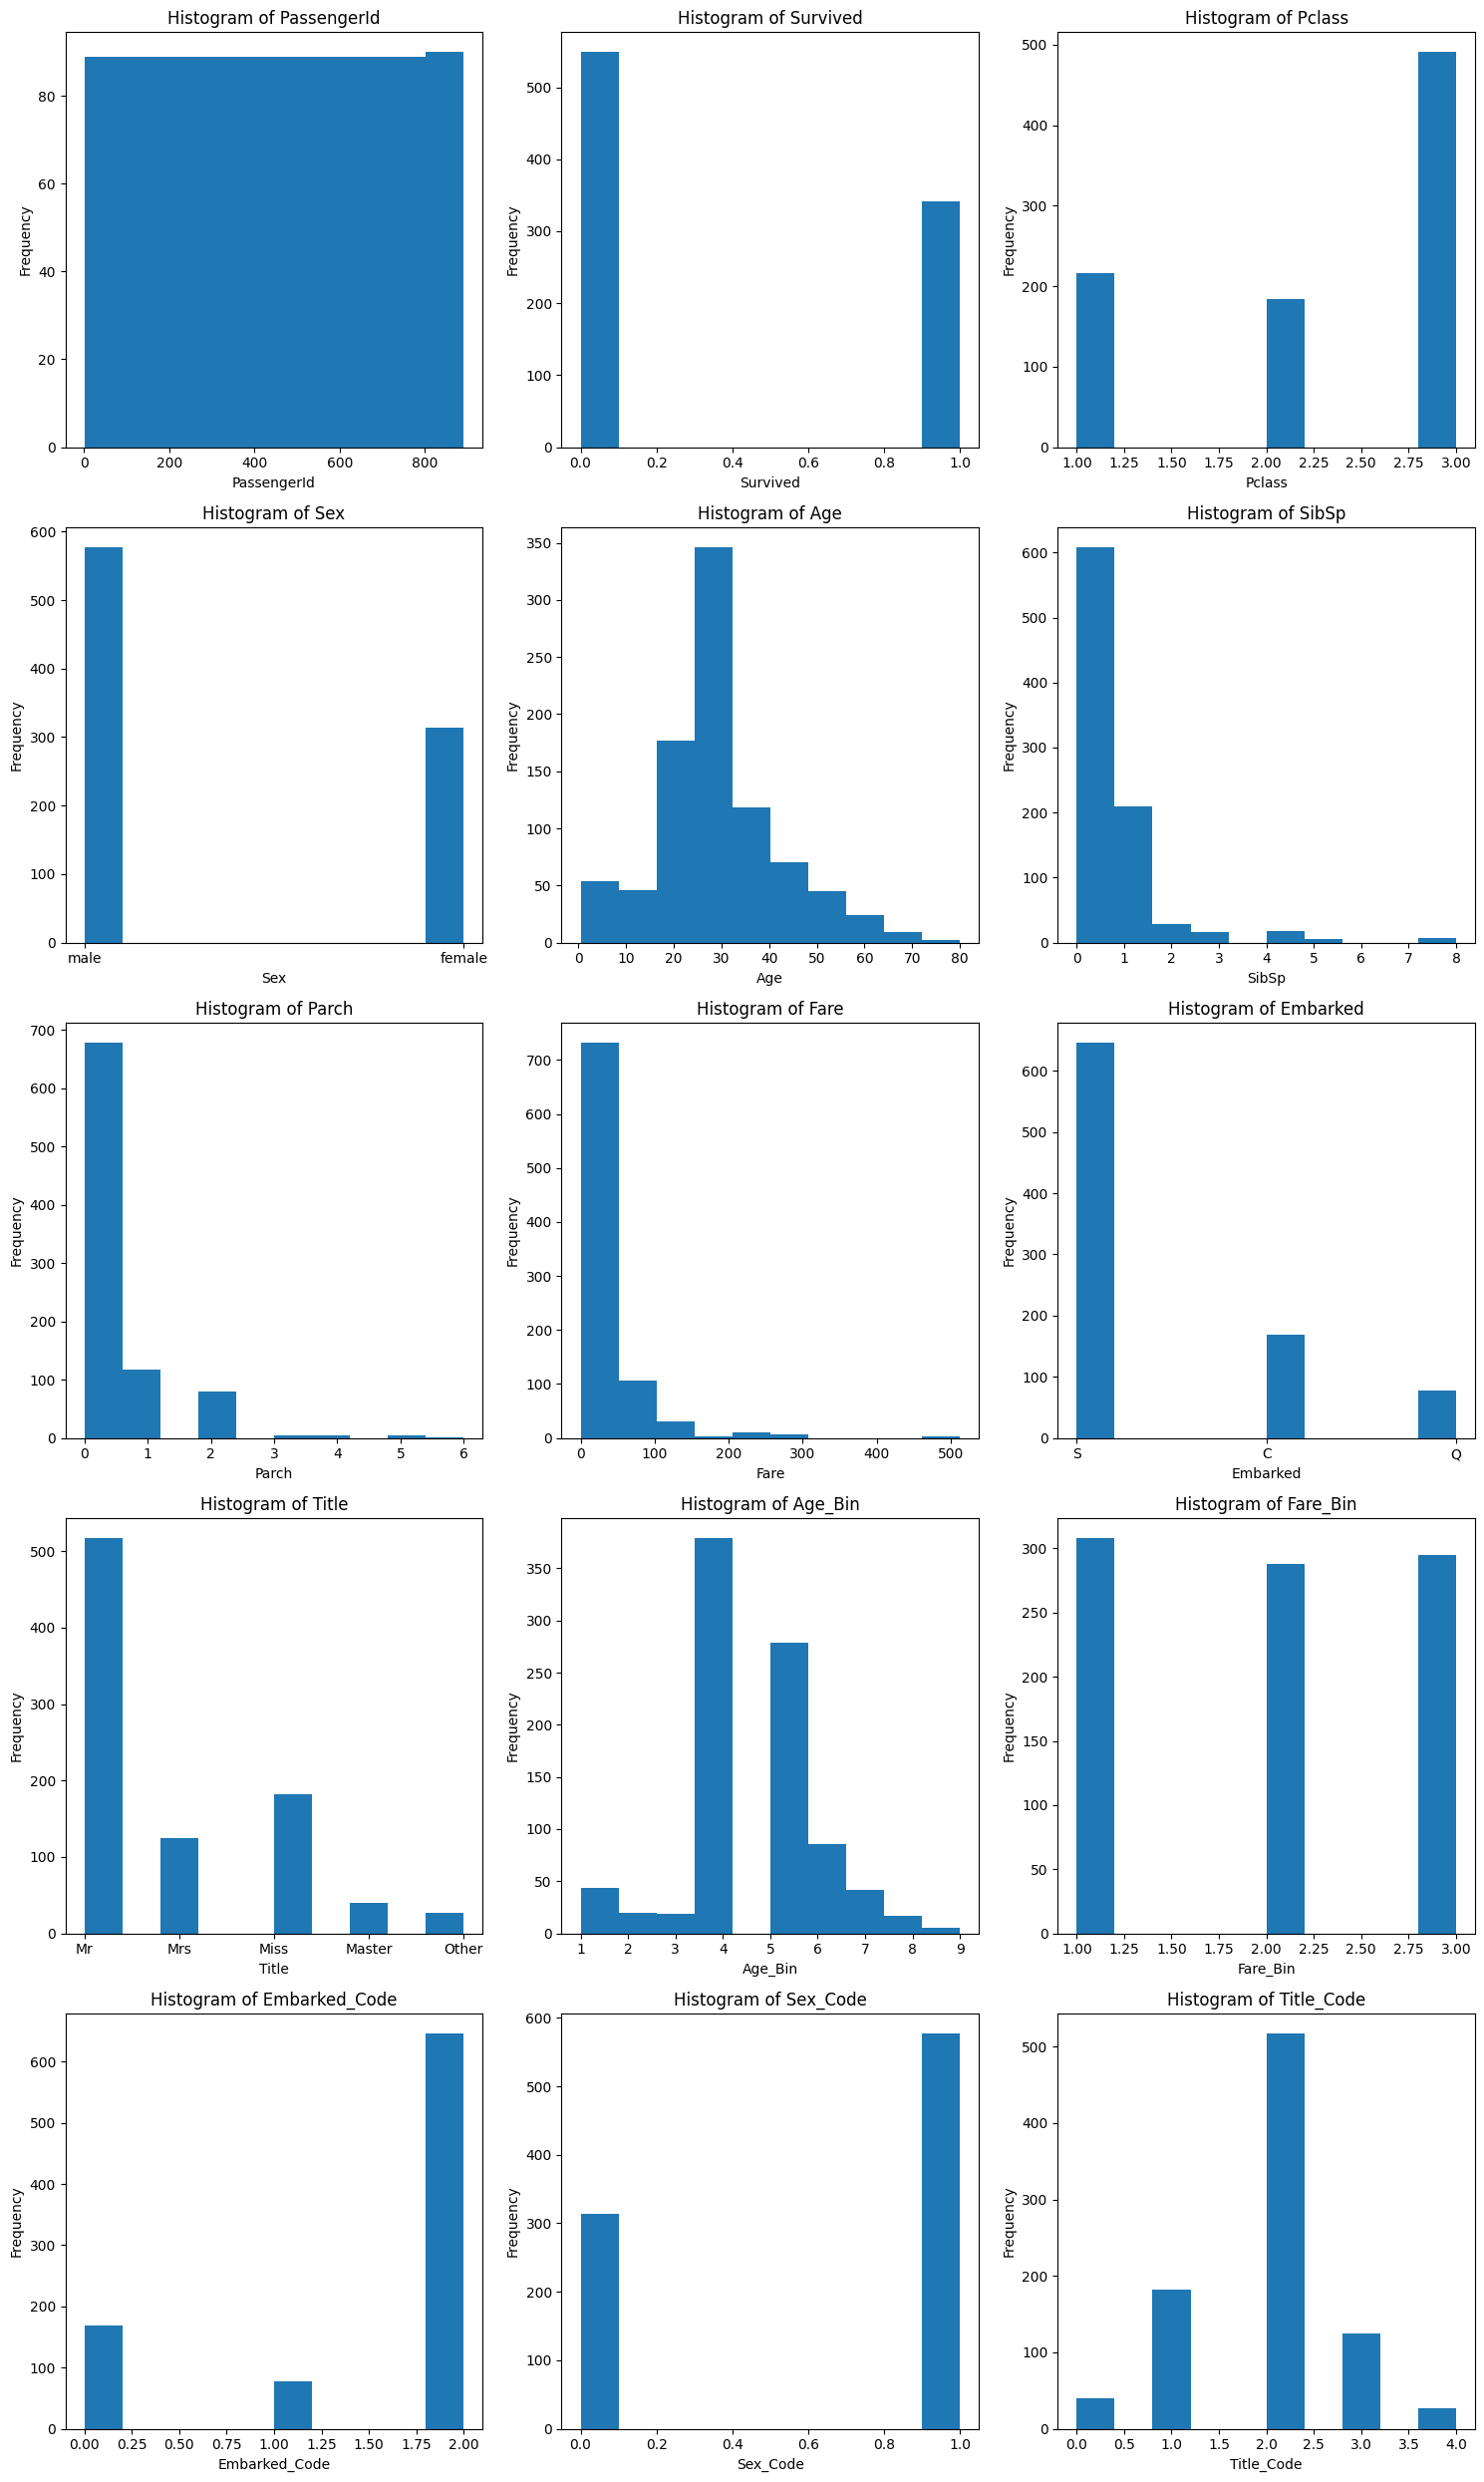

In [19]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

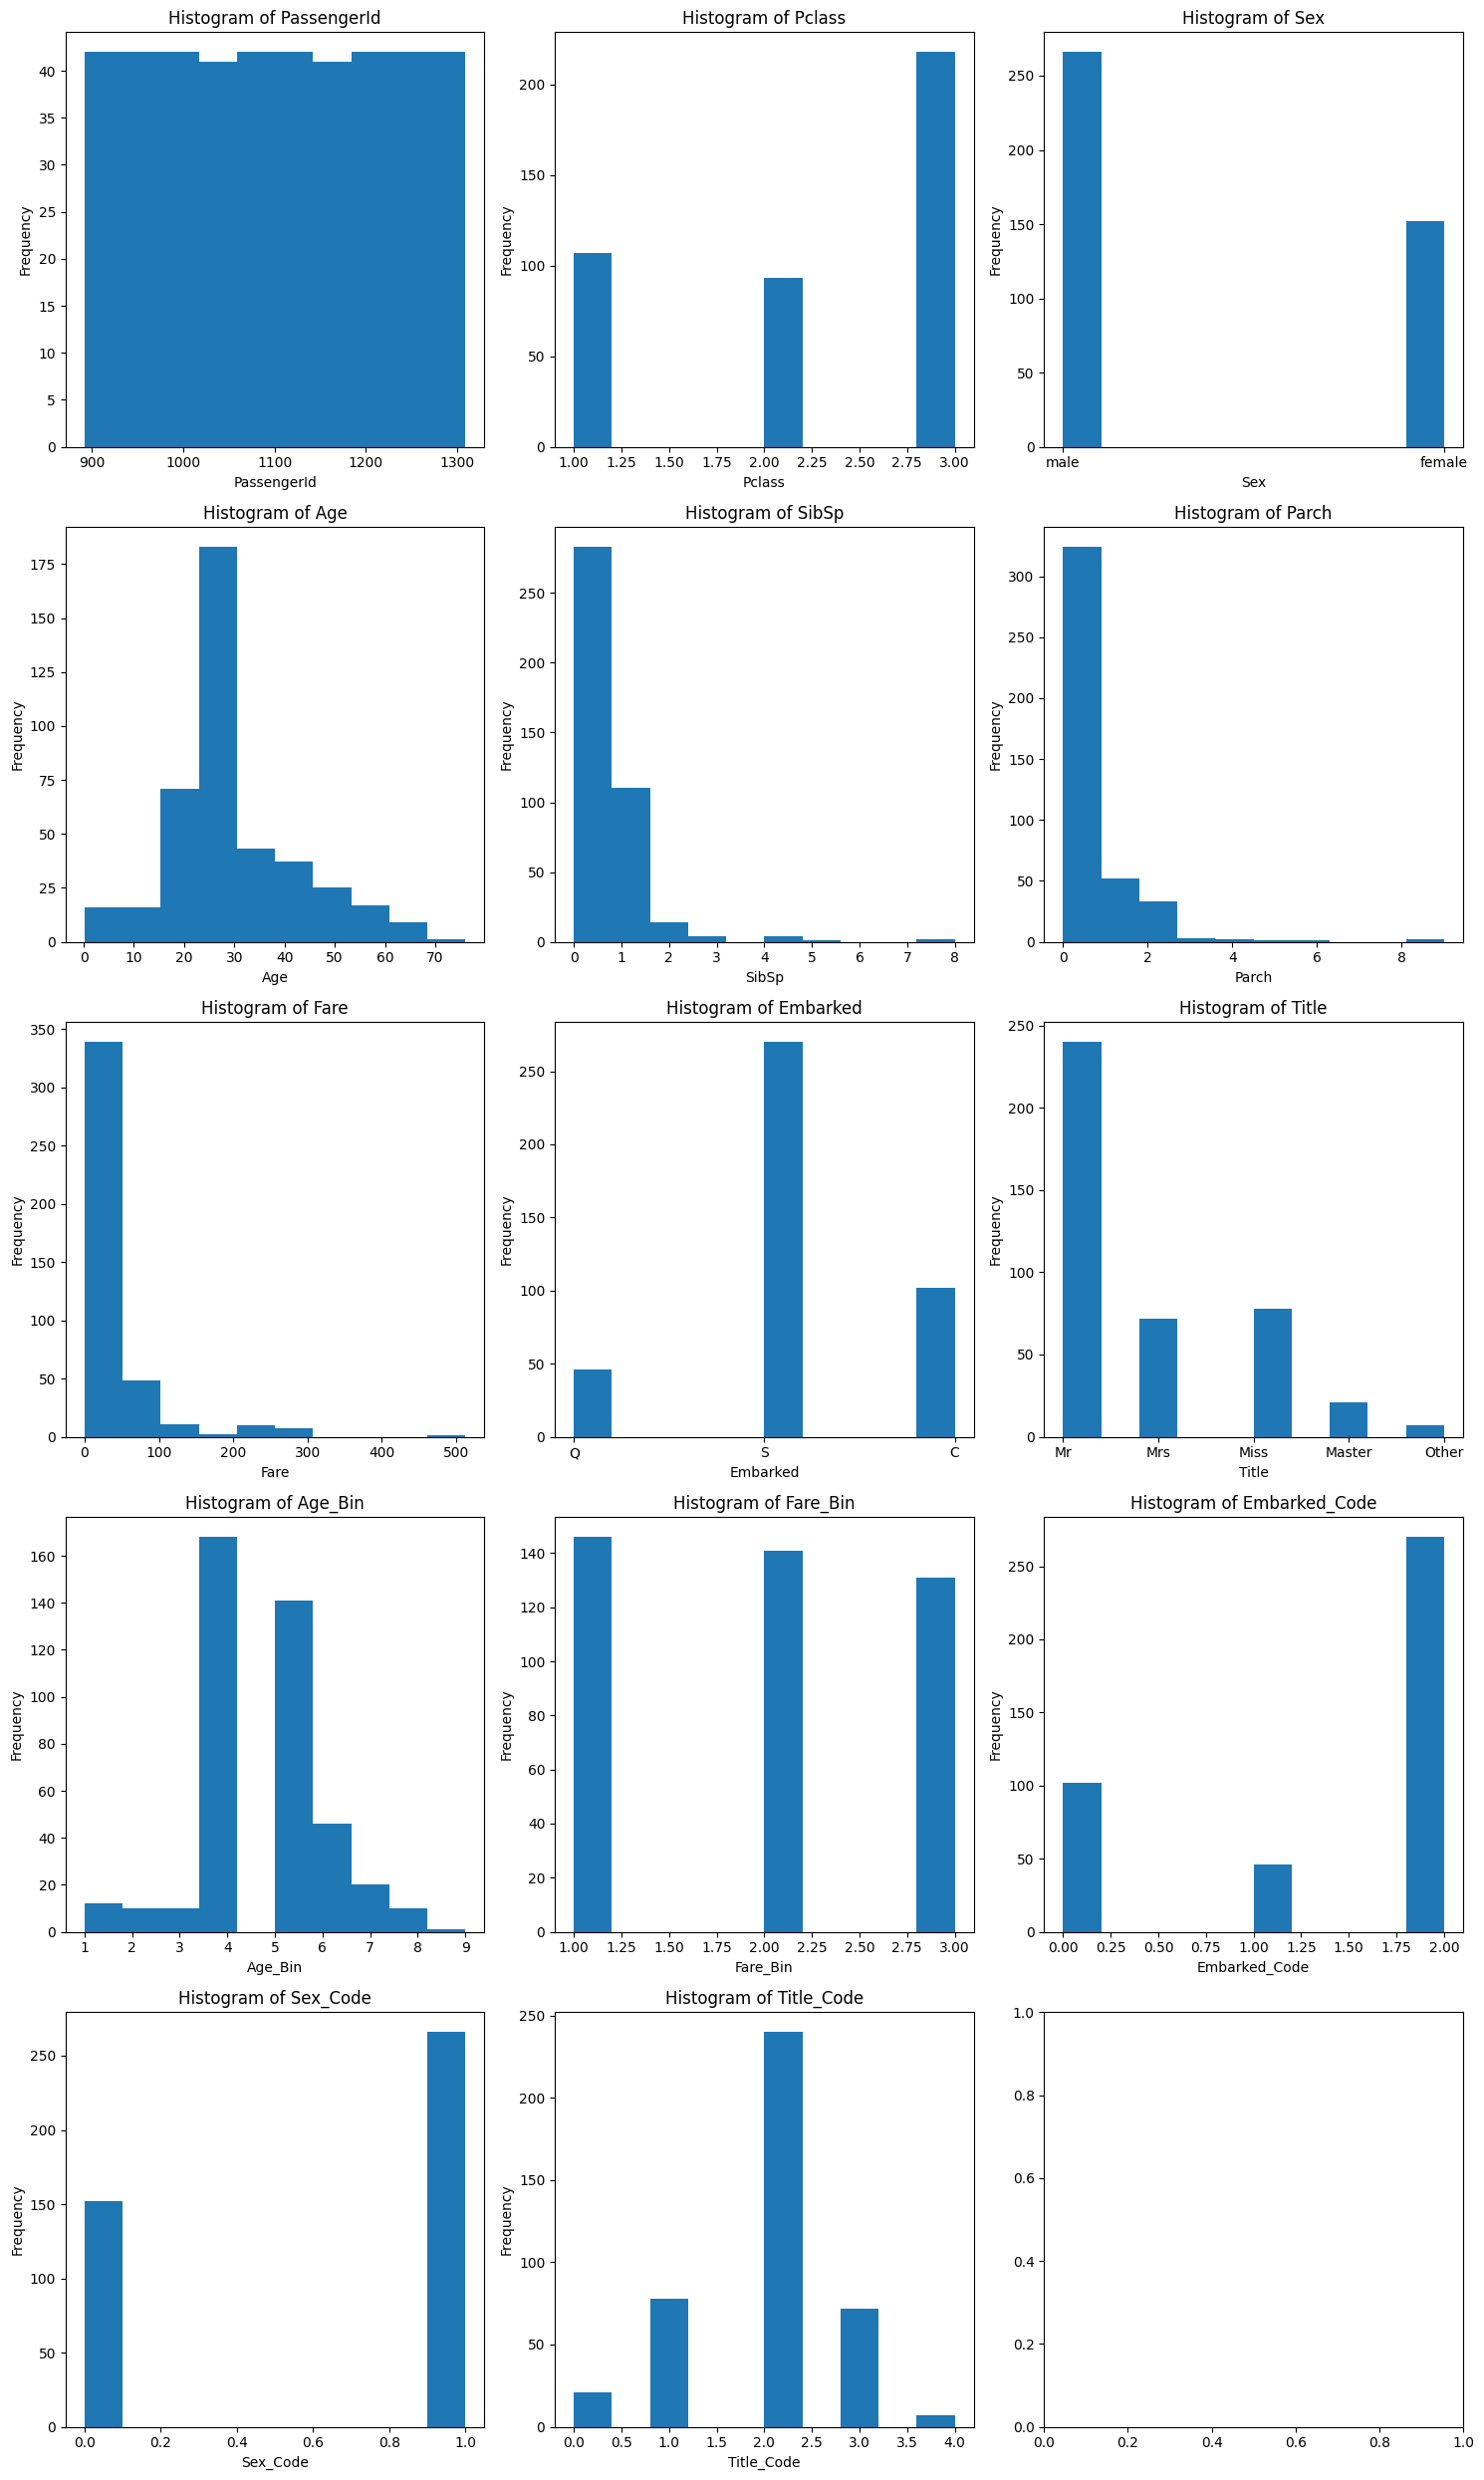

In [20]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df_test.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df_test[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

Now let's see how the information breaks down in terms of survival rates.

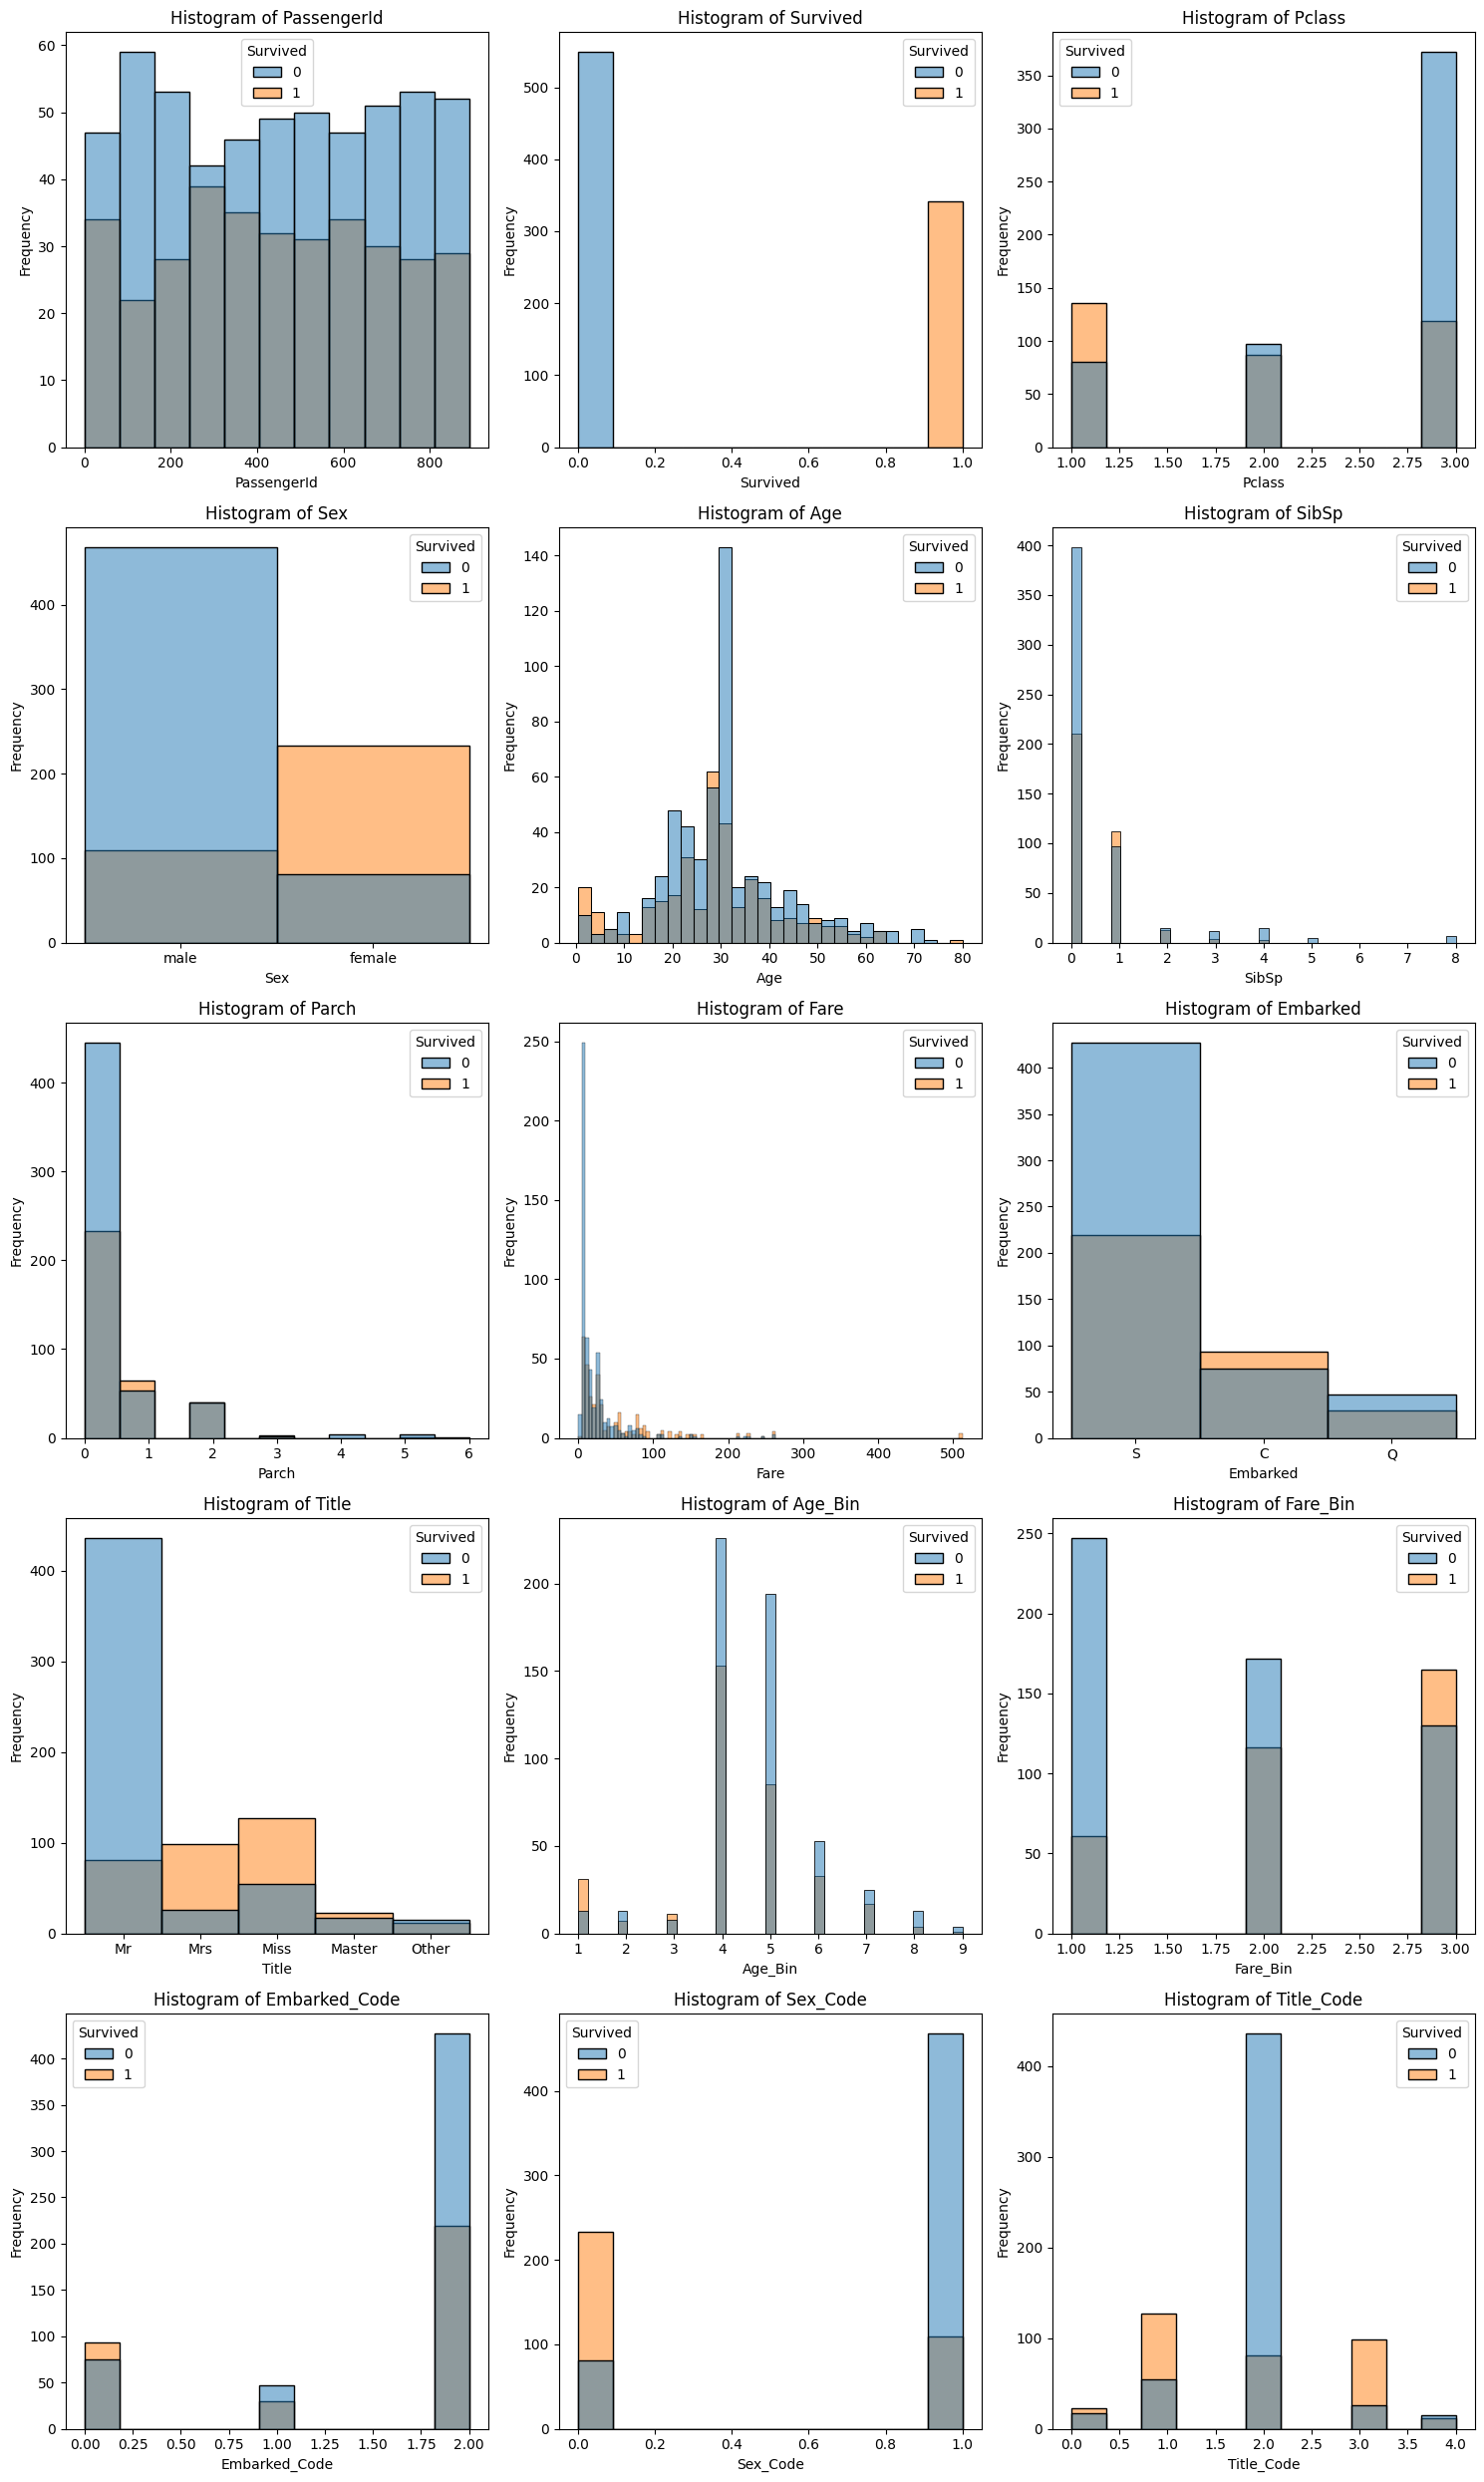

In [21]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=df, x=column, hue='Survived', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

Since age seems to be a major defining factor in survival rates, I want to make additional binary columns to distinguish if a passenger was a child or an elder. 

In [22]:
df['Child'] = ((df['Age'] < 16)).astype(int)
df['Elder'] = ((df['Age'] > 60)).astype(int)
df['Age*Class*Sex'] = df['Age'] * df['Pclass'] * (df['Sex_Code'] +1)

df_test['Child'] = ((df_test['Age'] < 16)).astype(int)
df_test['Elder'] = ((df_test['Age'] > 60)).astype(int)
df_test['Age*Class*Sex'] = df_test['Age'] * df_test['Pclass'] * (df_test['Sex_Code'] +1)

In [23]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,4,1,2,1,2,0,0,132.0
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,5,3,0,0,3,0,0,38.0
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,4,1,2,0,1,0,0,78.0
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,5,3,2,0,3,0,0,35.0
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,5,1,2,1,2,0,0,210.0


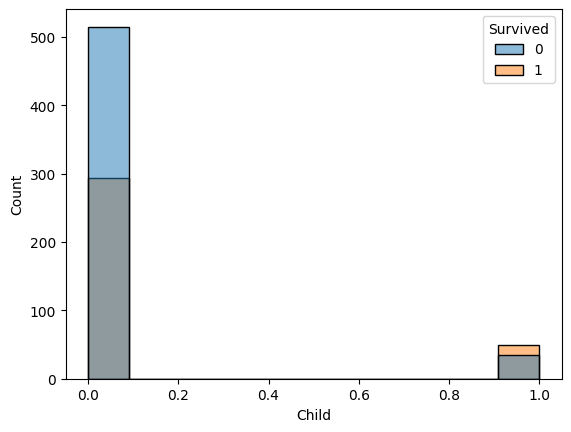

In [24]:
sns.histplot(data=df, x='Child', hue='Survived')
plt.show()

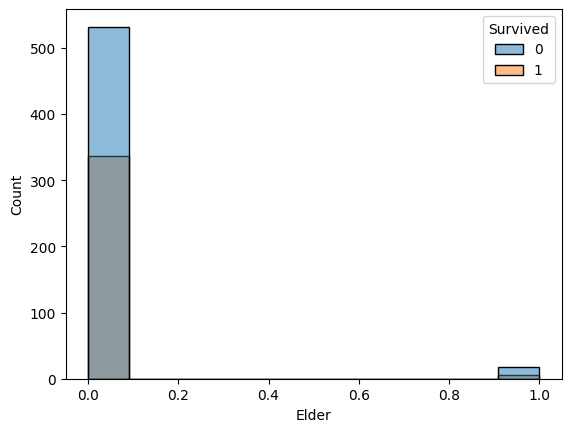

In [25]:
sns.histplot(data=df, x='Elder', hue='Survived')
plt.show()

We can see that survival rate appears to be much lower for those labeled as Elder's and much higher for those labeled as children. Let's use some pie charts to do some more survival rate comparisons.

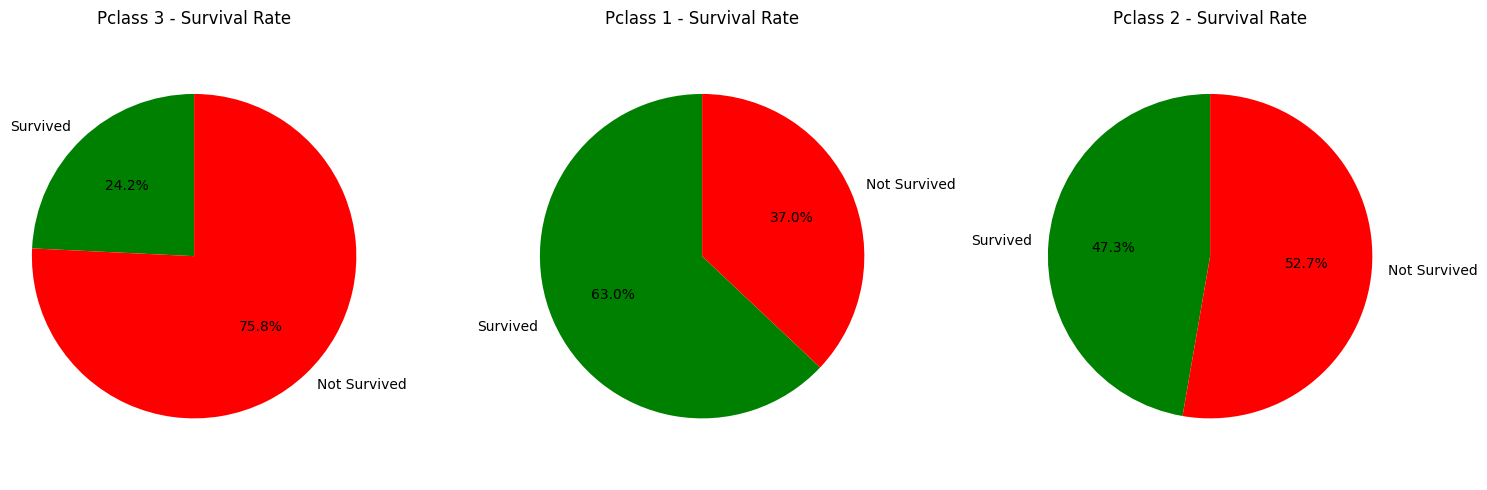

In [26]:
survived_percentage = df.groupby('Pclass')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Pclass'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

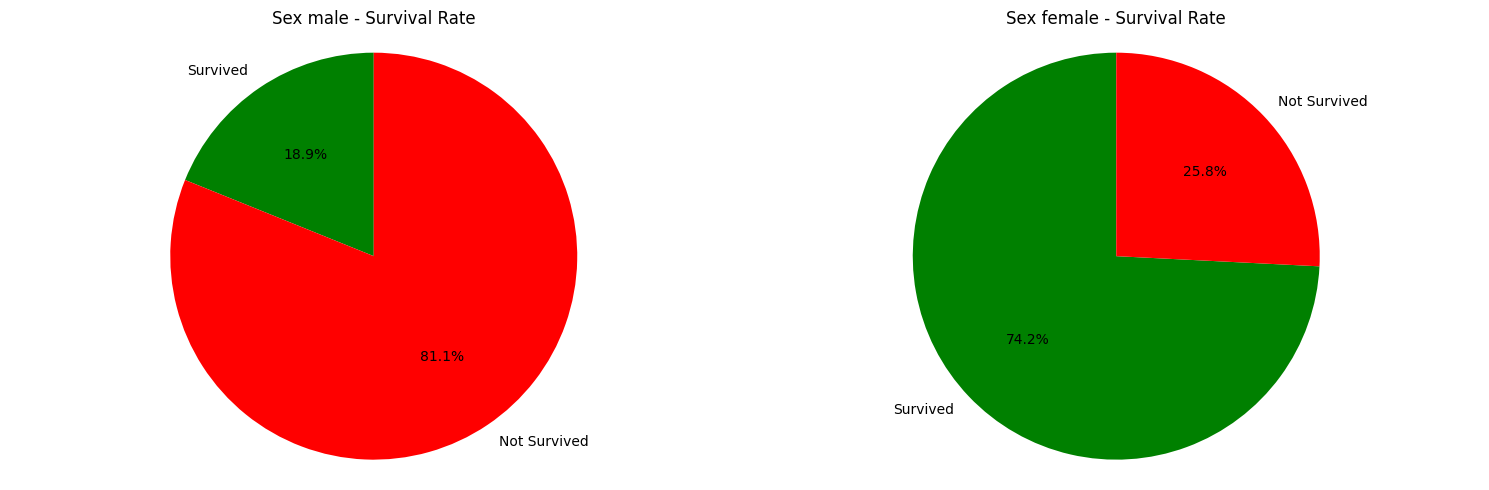

In [27]:
survived_percentage = df.groupby('Sex')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, pclass in enumerate(df['Sex'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Sex {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

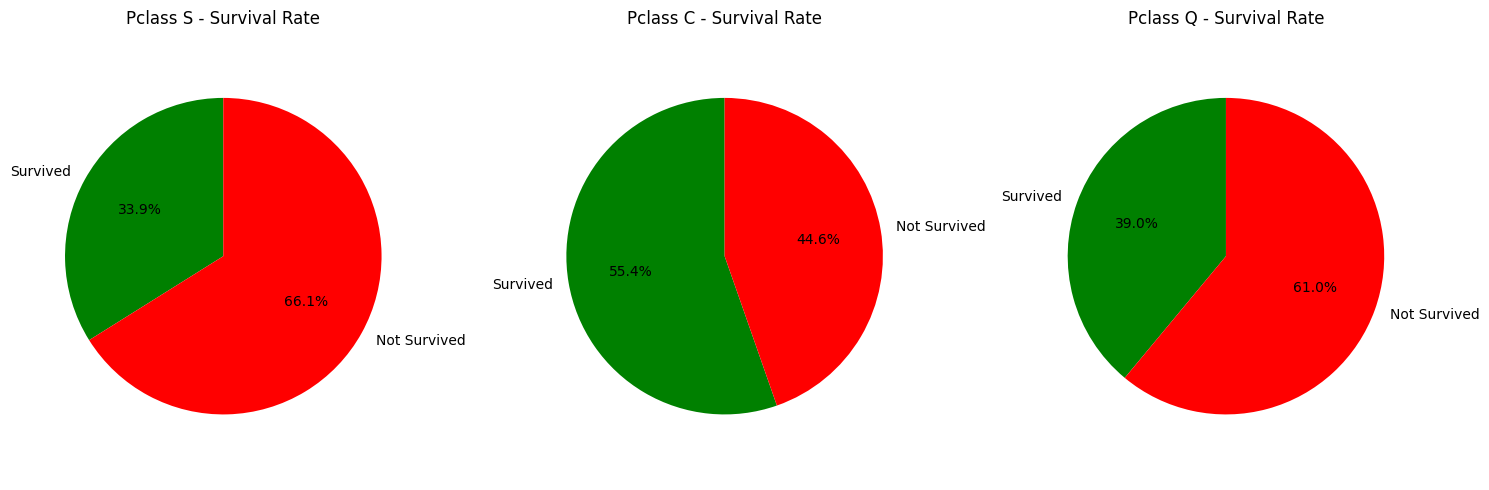

In [28]:
survived_percentage = df.groupby('Embarked')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Embarked'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

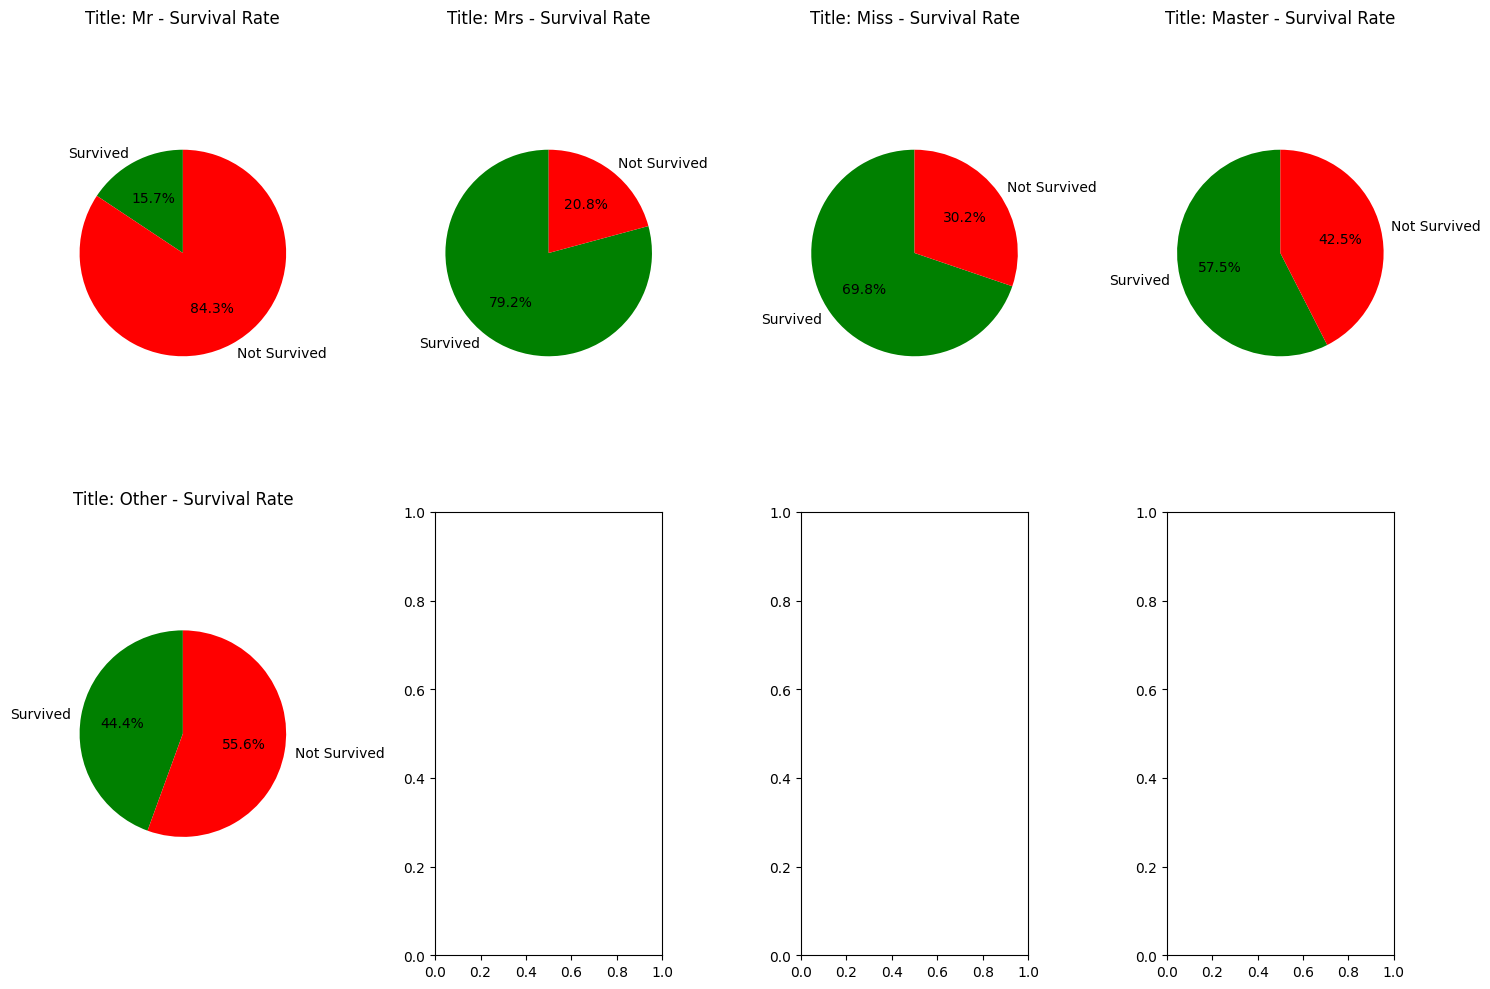

In [29]:
survived_percentage = df.groupby('Title')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, title in enumerate(df['Title'].unique()):
    row = i // 4
    col = i % 4
    
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[title], not_survived_percentage[title]]
    colors = ['green', 'red']
    
    ax = axes[row, col]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Title: {title} - Survival Rate')

plt.tight_layout()

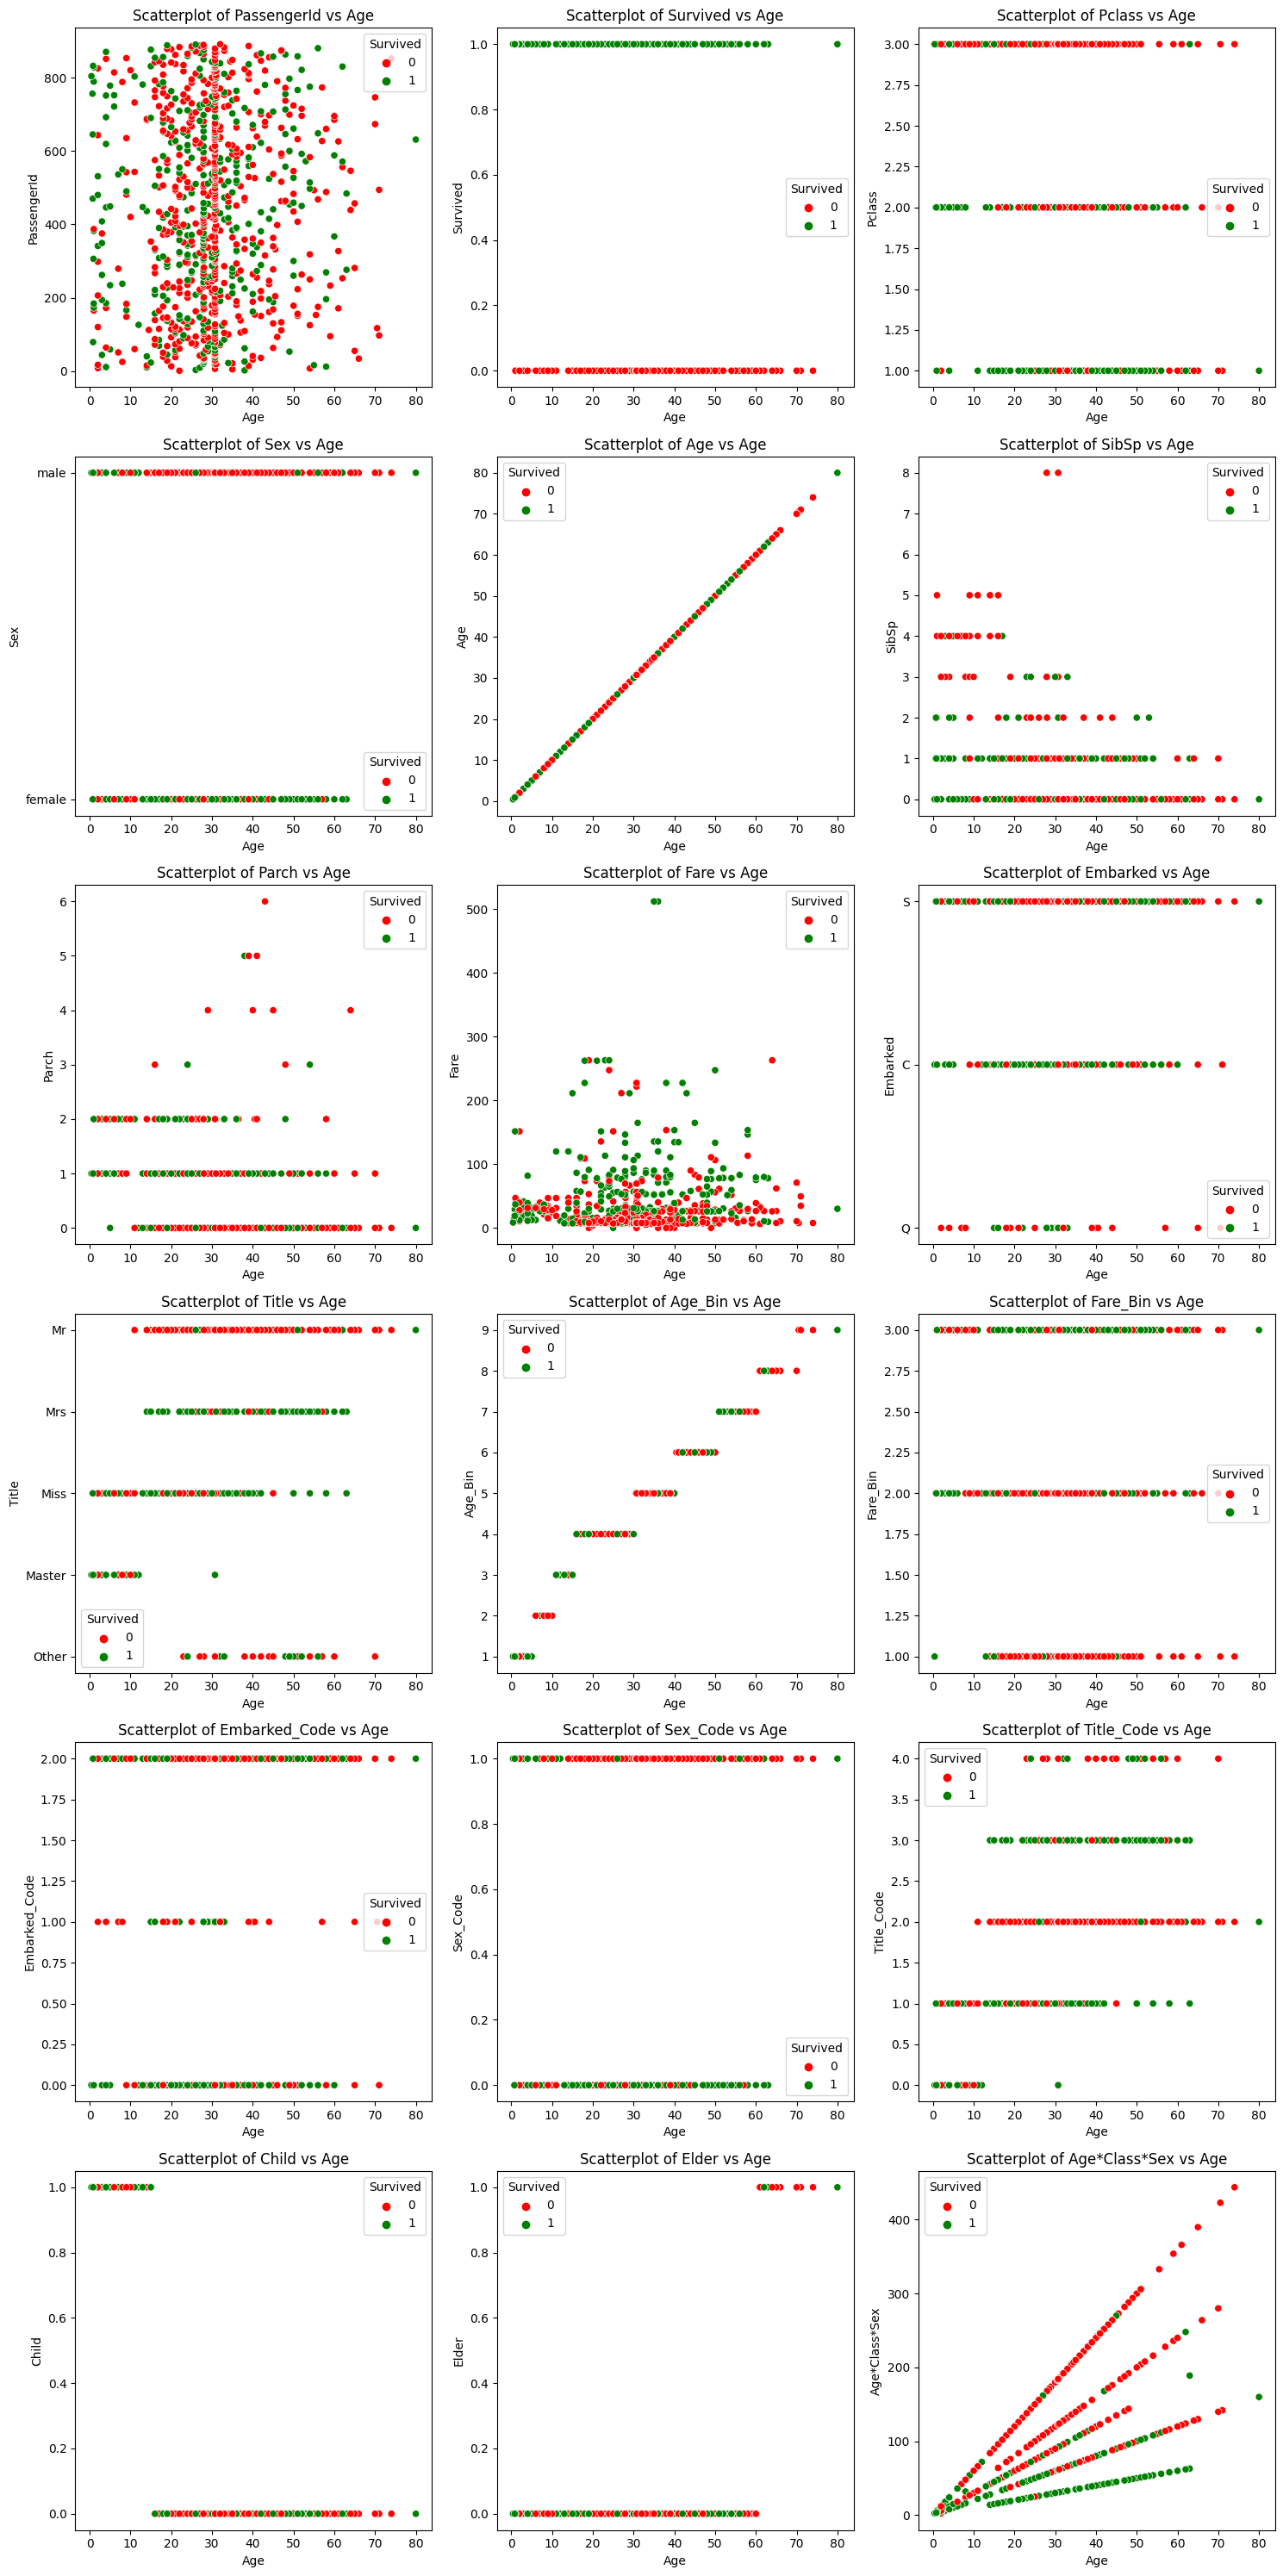

In [30]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.scatterplot(data=df, x='Age', y=column, hue='Survived', palette=['red', 'green'], ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel(column)
    ax.set_title(f'Scatterplot of {column} vs Age')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

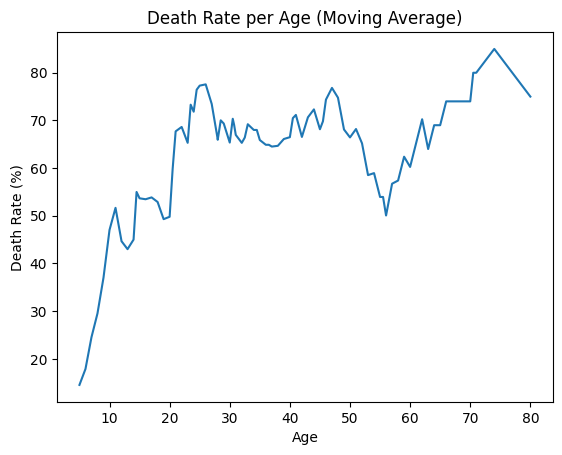

In [31]:
death_rate_per_age = df.groupby(['Age'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)

moving_average = death_rate_per_age.rolling(window=10).mean()
plt.plot(death_rate_per_age.index, moving_average)
plt.xlabel('Age')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age (Moving Average)')
plt.show()

<Axes: xlabel='Pclass', ylabel='Survived'>

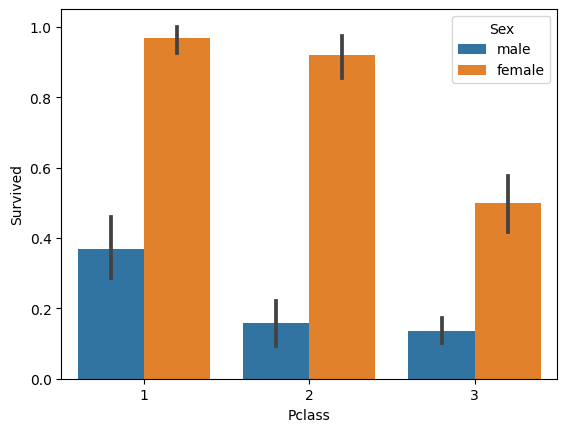

In [32]:
sns.barplot(data=df, x='Pclass', y='Survived',hue='Sex')

<Axes: xlabel='Parch', ylabel='Survived'>

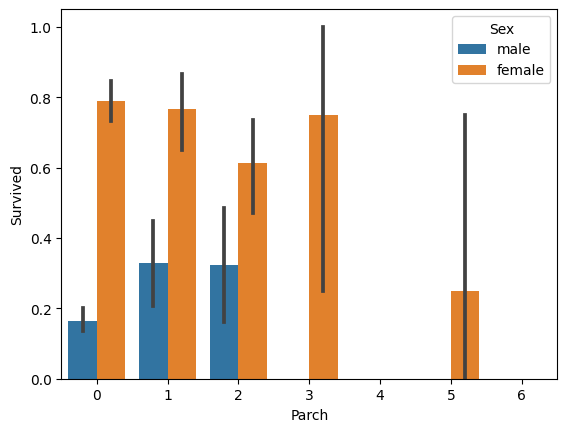

In [33]:
sns.barplot(data=df, x='Parch', y='Survived',hue='Sex')

We can see that elements such as Sex, Class, Title, Age, and Parch all have impacts on survival rate. I want to explore if the size of someones guest list can be exploited further to find more insights. I'll make a column called Family size, and then corresponding Alone & Big Family binary columns to see if that provides more information.

In [34]:
df['Fam_Size'] = df['SibSp'] + df['Parch'] + 1
df_test['Fam_Size'] = df_test['SibSp'] + df_test['Parch'] + 1

In [35]:
df['Alone'] = ((df['Fam_Size'] == 1)).astype(int)
df['Family_Category'] = pd.cut(df['Fam_Size'], bins=[0, 1, 4, 6, float('inf')], labels=['Alone', 'Small', 'Medium', 'Large'])


In [36]:
df_test['Alone'] = ((df_test['Fam_Size'] == 1)).astype(int)
df_test['Family_Category'] = pd.cut(df['Fam_Size'], bins=[0, 1, 4, 6, float('inf')], labels=['Alone', 'Small', 'Medium', 'Large'])

In [37]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Title', 'Age_Bin', 'Fare_Bin', 'Embarked_Code',
       'Sex_Code', 'Title_Code', 'Child', 'Elder', 'Age*Class*Sex', 'Fam_Size',
       'Alone', 'Family_Category'],
      dtype='object')

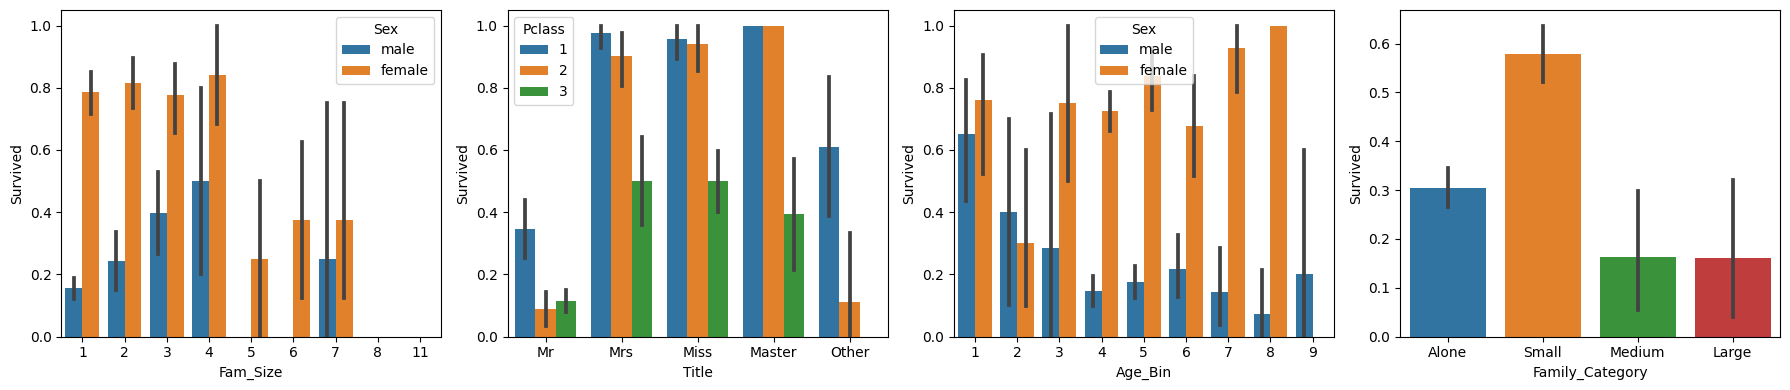

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

sns.barplot(data=df, x='Fam_Size', y='Survived', hue='Sex', ax=axes[0])
sns.barplot(data=df, x='Title', y='Survived', hue='Pclass', ax=axes[1])
sns.barplot(data=df, x='Age_Bin', y='Survived', hue='Sex', ax=axes[2])
sns.barplot(data=df, x='Family_Category', y='Survived', ax=axes[3])

plt.tight_layout()

So we now have a good idea of the variations in survival rate based on various passenger attributes. What I want to do now is quantify that survival change as some sort of score. I'll make a new dataframe that is based on the survival rate of various columns to see if I can give people a score based on how many high risk/medium risk or low risk attributes they have.

In [39]:
average_survival_rate_per_pclass = df.groupby('Pclass')['Survived'].mean()
average_survival_rate_per_sex = df.groupby('Sex')['Survived'].mean()
average_survival_rate_per_title = df.groupby('Title')['Survived'].mean()
average_survival_rate_per_age_bin = df.groupby('Age_Bin')['Survived'].mean()
average_survival_rate_per_fare_bin = df.groupby('Fare_Bin')['Survived'].mean()
average_survival_rate_per_embarked = df.groupby('Embarked')['Survived'].mean()

In [40]:
df_survival_rate = df.copy()

In [41]:
df_survival_rate['Survival_Rate_Pclass'] = df_survival_rate['Pclass'].map(average_survival_rate_per_pclass)
df_survival_rate['Survival_Rate_Sex'] = df_survival_rate['Sex'].map(average_survival_rate_per_sex)
df_survival_rate['Survival_Rate_Title'] = df_survival_rate['Title'].map(average_survival_rate_per_title)
df_survival_rate['Survival_Rate_Age_Bin'] = df_survival_rate['Age_Bin'].map(average_survival_rate_per_age_bin)
df_survival_rate['Survival_Rate_Fare_Bin'] = df_survival_rate['Fare_Bin'].map(average_survival_rate_per_fare_bin)
df_survival_rate['Survival_Rate_Embarked'] = df_survival_rate['Embarked'].map(average_survival_rate_per_embarked)

df_survival_rate['Survival_Level_Pclass'] = pd.cut(df_survival_rate['Survival_Rate_Pclass'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Sex'] = pd.cut(df_survival_rate['Survival_Rate_Sex'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Title'] = pd.cut(df_survival_rate['Survival_Rate_Title'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Age_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Age_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Fare_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Fare_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Embarked'] = pd.cut(df_survival_rate['Survival_Rate_Embarked'], bins=4, labels=[1, 2, 3, 4]).astype(int)

df_survival_rate['Survival_Level_Sum'] = df_survival_rate[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked']].sum(axis=1)

In [42]:
df_survival_rate.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Survival_Rate_Age_Bin,Survival_Rate_Fare_Bin,Survival_Rate_Embarked,Survival_Level_Pclass,Survival_Level_Sex,Survival_Level_Title,Survival_Level_Age_Bin,Survival_Level_Fare_Bin,Survival_Level_Embarked,Survival_Level_Sum
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,...,0.403694,0.198052,0.339009,1,1,1,2,1,1,7
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,...,0.304659,0.559322,0.553571,4,4,4,1,4,4,21
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,...,0.403694,0.198052,0.339009,1,4,4,2,1,1,13
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,...,0.304659,0.559322,0.339009,4,4,4,1,4,1,18
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,...,0.304659,0.198052,0.339009,1,1,1,1,1,1,6


Great, so we now have 4 survival levels for some key columns (1 for low survival rate, 4 for high). Let's use this info to decide how to add some survival scores to our main dataframe.

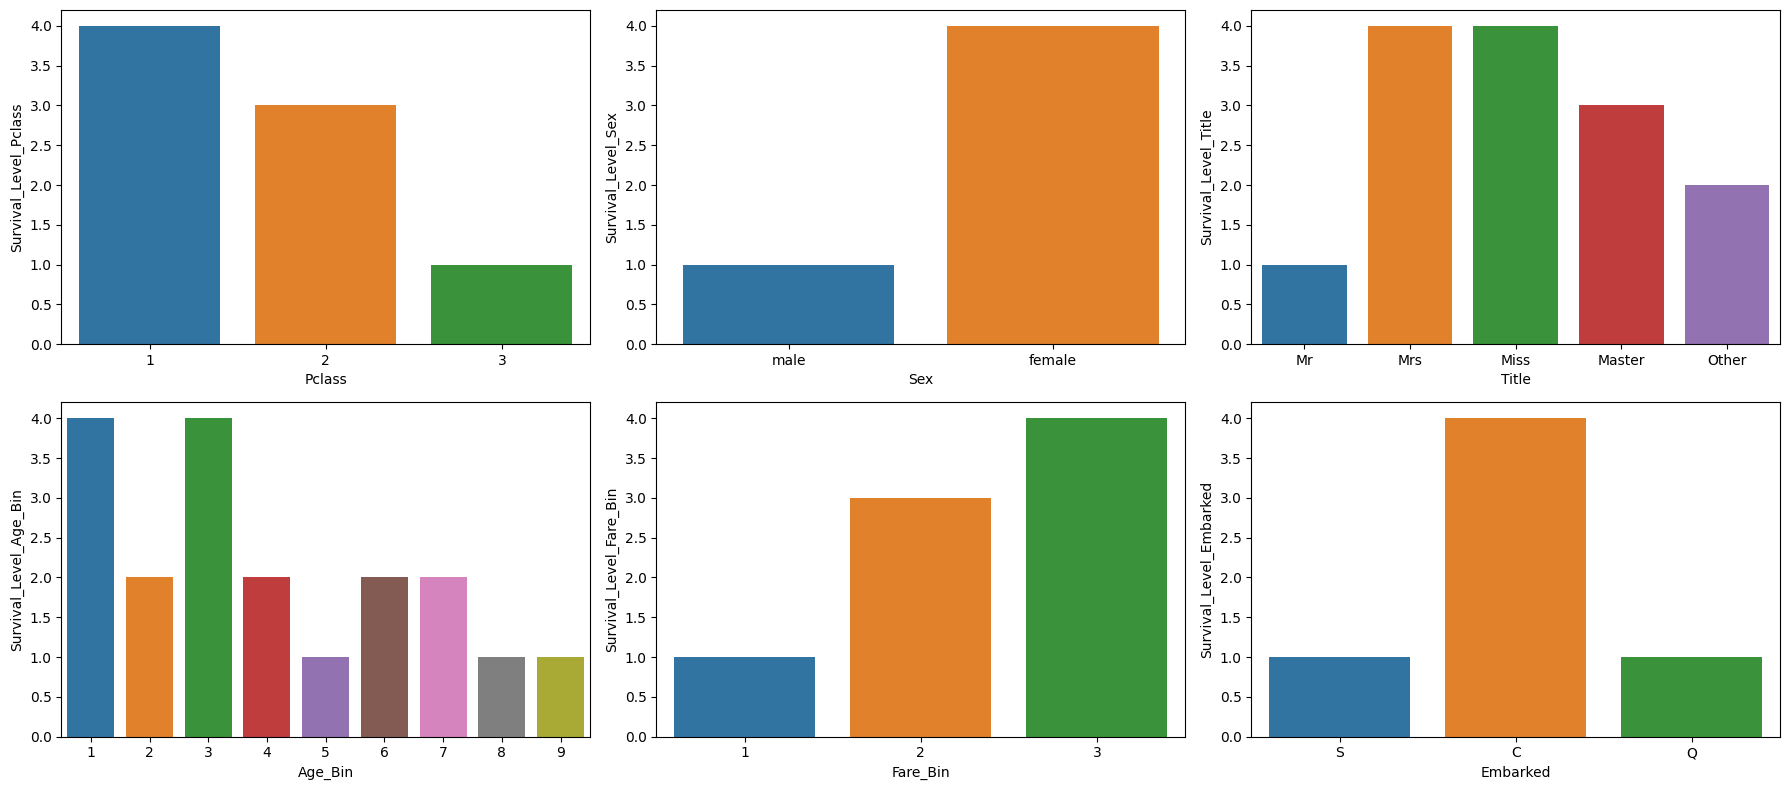

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

sns.barplot(data=df_survival_rate, x='Pclass', y='Survival_Level_Pclass', ax=axes[0, 0])
sns.barplot(data=df_survival_rate, x='Sex', y='Survival_Level_Sex', ax=axes[0, 1])
sns.barplot(data=df_survival_rate, x='Title', y='Survival_Level_Title', ax=axes[0, 2])

sns.barplot(data=df_survival_rate, x='Age_Bin', y='Survival_Level_Age_Bin', ax=axes[1, 0])
sns.barplot(data=df_survival_rate, x='Fare_Bin', y='Survival_Level_Fare_Bin', ax=axes[1, 1])
sns.barplot(data=df_survival_rate, x='Embarked', y='Survival_Level_Embarked', ax=axes[1, 2])

plt.tight_layout()



Based on these visuals, I can apply a score to different values in those columns. For instance, someone in first class can have a 3 survival score since they are most likely to survive amongst that variable. I'll aim for 3 levels per variable, however for extreme discrepencies, I may keep all 4 survival levels for certain columns.

Mapping the column values to their respective survival level.

In [44]:
def add_survival_levels(df):
    df['Survival_Level_Pclass'] = df['Pclass'].map({1: 3, 2: 2, 3: 1}).astype(int)
    df['Survival_Level_Sex'] = df['Sex'].map({'male': 1, 'female': 3}).astype(int)
    df['Survival_Level_Title'] = df['Title'].map({'Mr': 1, 'Mrs': 4, 'Miss': 4, 'Master': 3, 'Other': 2}).astype(int)
    df['Survival_Level_Age_Bin'] = df['Age_Bin'].map({1: 4, 2: 2, 3: 4, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 1}).astype(int)
    df['Survival_Level_Fare_Bin'] = df['Fare_Bin'].map({1: 1, 2: 2, 3: 3}).astype(int)
    df['Survival_Level_Embarked'] = df['Embarked'].map({'S': 1, 'C': 3, 'Q': 1}).astype(int)
    df['Survival_Level_Family'] = df['Family_Category'].map({'Medium': 3, 'Large': 3, 'Alone': 2, 'Small': 1}).astype(int)

    df['Survival_Level_Sum'] = df[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family']].sum(axis=1)
    return df


In [45]:
df = add_survival_levels(df)
df_test = add_survival_levels(df_test)

Drop the uneeded extra columns.

In [46]:
df.drop(['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family'], axis=1, inplace=True)
df_test.drop(['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family'], axis=1, inplace=True)


In [47]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Level_Sum
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,...,2,1,2,0,0,132.0,2,0,Small,8
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,...,0,0,3,0,0,38.0,2,0,Small,18
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,...,2,0,1,0,0,78.0,1,1,Alone,14
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,...,2,0,3,0,0,35.0,2,0,Small,16
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,...,2,1,2,0,0,210.0,1,1,Alone,8


In [48]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_Bin,...,Embarked_Code,Sex_Code,Title_Code,Child,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Level_Sum
0,892,3,male,34.5,0,0,7.8292,Q,Mr,5,...,1,1,2,0,0,207.0,1,1,Small,7
1,893,3,female,47.0,1,0,7.0000,S,Mrs,6,...,2,0,3,0,0,141.0,2,0,Small,13
2,894,2,male,62.0,0,0,9.6875,Q,Mr,8,...,1,1,2,0,1,248.0,1,1,Alone,10
3,895,3,male,27.0,0,0,8.6625,S,Mr,4,...,2,1,2,0,0,162.0,1,1,Small,8
4,896,3,female,22.0,1,1,12.2875,S,Mrs,4,...,2,0,3,0,0,66.0,3,0,Alone,15


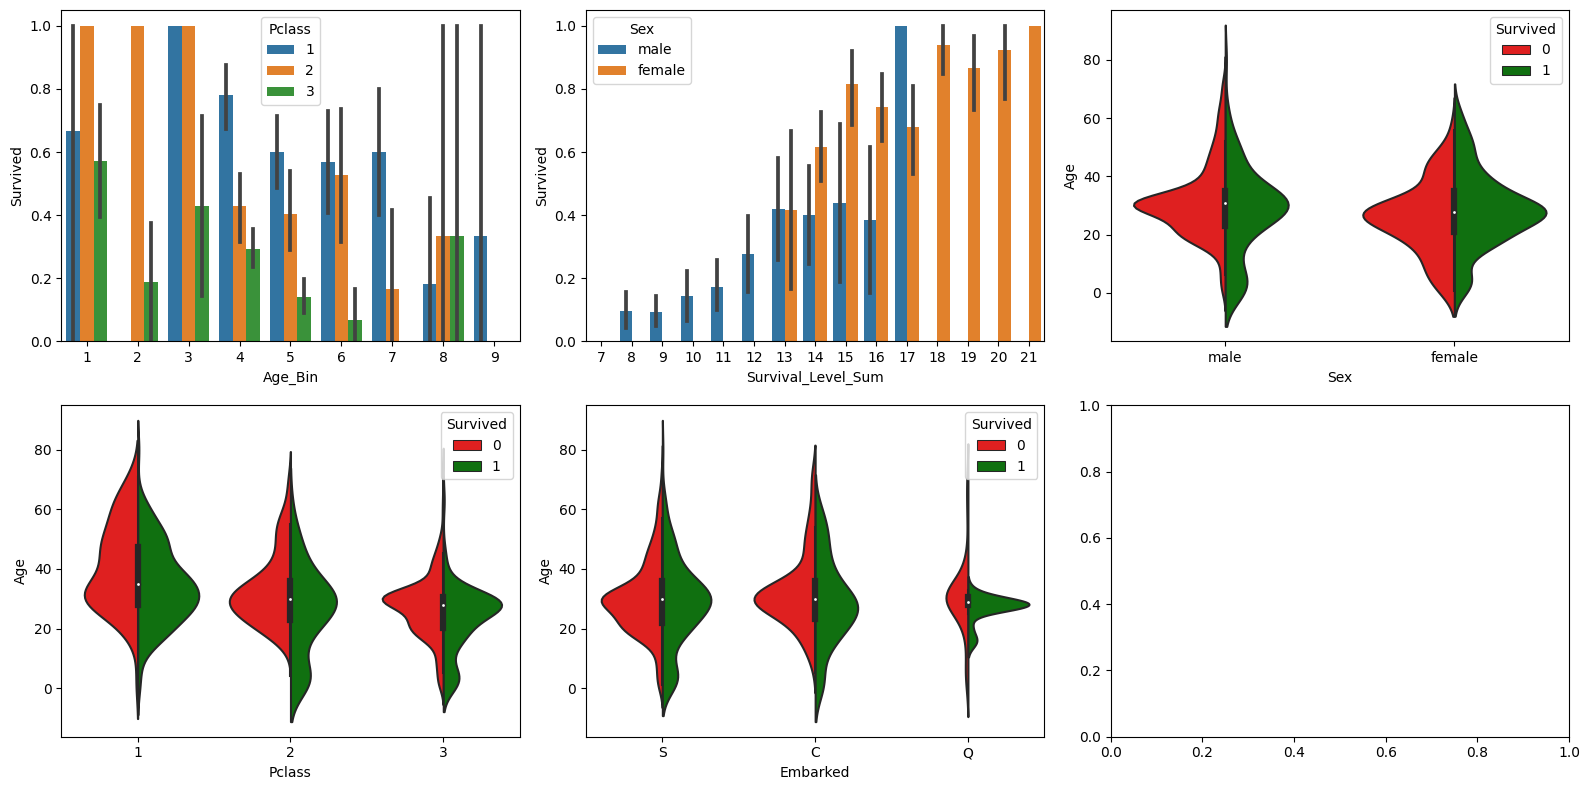

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

sns.barplot(data=df, x='Age_Bin', y='Survived', hue='Pclass', ax=axes[0, 0])
sns.barplot(data=df, x='Survival_Level_Sum', y='Survived', hue='Sex', ax=axes[0, 1])
sns.violinplot(data=df, x='Sex', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[0, 2])
sns.violinplot(data=df, x='Pclass', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[1, 0])
sns.violinplot(data=df, x='Embarked', y='Age', hue='Survived', split=True, palette=['red', 'green'], ax=axes[1, 1])

plt.tight_layout()


Let's see if we can bin the survival level sum to a smaller number of categories to better generalize the data. Let's review the survival rates per level to see what binning makes the most sense.

In [50]:
survival_rate = df.groupby('Survival_Level_Sum')['Survived'].mean()
print(survival_rate)


Survival_Level_Sum
7     0.000000
8     0.096491
9     0.092857
10    0.144737
11    0.172840
12    0.275862
13    0.418605
14    0.533898
15    0.703704
16    0.683544
17    0.687500
18    0.939394
19    0.866667
20    0.923077
21    1.000000
Name: Survived, dtype: float64


In [51]:
df['Survival_Chance'] = pd.cut(df['Survival_Level_Sum'], bins=[0, 11, 14, 17, float('inf')], labels=[1, 2, 3, 4]).astype(int)
df_test['Survival_Chance'] = pd.cut(df['Survival_Level_Sum'], bins=[0, 11, 14, 17, float('inf')], labels=[1, 2, 3, 4]).astype(int)



In [52]:
survival_rate = df.groupby('Survival_Chance')['Survived'].mean()
print(survival_rate)

Survival_Chance
1    0.118644
2    0.442922
3    0.690608
4    0.910256
Name: Survived, dtype: float64


Now let's review what the correlation is between our variables and survival to start determining which columns to use in our models.

In [53]:
df = df.drop(['PassengerId', 'Embarked', 'Title', 'Survival_Level_Sum'], axis=1)
df_test = df_test.drop(['SibSp','Embarked', 'Title', 'Survival_Level_Sum'], axis=1)

/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_33120/827375925.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


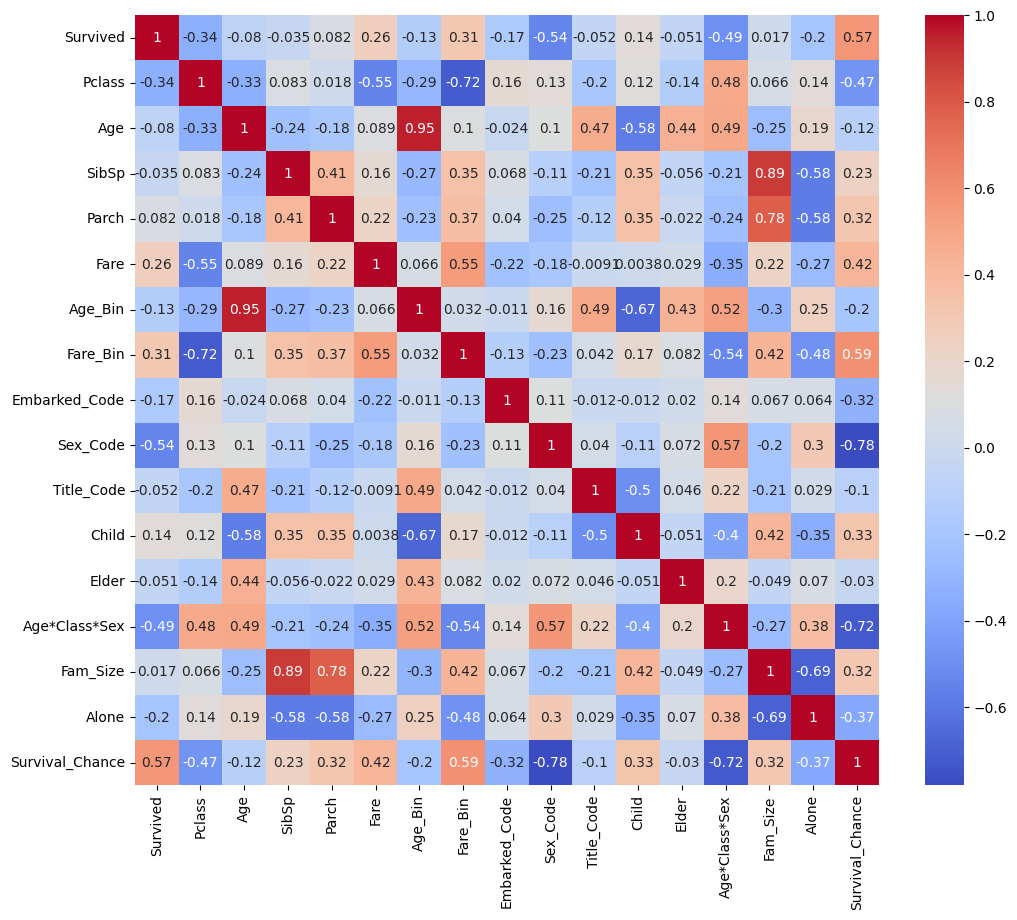

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [55]:
survived_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
print(survived_correlation)

Survived           1.000000
Survival_Chance    0.567719
Fare_Bin           0.305799
Fare               0.257307
Child              0.136107
Parch              0.081629
Fam_Size           0.016639
SibSp             -0.035322
Elder             -0.051224
Title_Code        -0.052471
Age               -0.080453
Age_Bin           -0.134327
Embarked_Code     -0.167675
Alone             -0.203367
Pclass            -0.338481
Age*Class*Sex     -0.490638
Sex_Code          -0.543351
Name: Survived, dtype: float64


I'm also going to check the feature importance using a decision tree model to further review the impact features have on the Survival outcome prediction.

In [56]:
X = df.drop(['Survived', 'Sex', 'Family_Category', 'Age'], axis=1)
y = df['Survived']

rf = RandomForestClassifier()
rf.fit(X, y)

feature_importances = rf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

for index in sorted_indices:
    feature = X.columns[index]
    importance = feature_importances[index]
    print(f'{feature}: {importance}')
    


Age*Class*Sex: 0.27816269098227536
Fare: 0.19728537483095684
Sex_Code: 0.11824223190230647
Survival_Chance: 0.0757924335467728
Title_Code: 0.07487127220579863
Pclass: 0.05334998515166648
Fam_Size: 0.043858681305161365
Age_Bin: 0.042053101362934525
SibSp: 0.030704053595465543
Embarked_Code: 0.02621451234403689
Fare_Bin: 0.024041354865546347
Parch: 0.016739665806266964
Alone: 0.008709198002247395
Child: 0.007318384266793238
Elder: 0.0026570598317713005


I'll mainly try a different variation of these features to see which has the best results with the models.

In [57]:
cat_columns = ['Survival_Chance', 'Sex_Code', 'Pclass', 'Age_Bin', 'Title_Code', 'Family_Category', 'Fare_Bin', 'Embarked_Code', 'Alone', 'Child', 'Elder']
num_columns = ['Age*Class*Sex']
target = 'Survived'

I'm going to train test split the data, then split the test data into test and validation sets.

In [58]:
X_train_temp, X_test_valid, y_train_temp, y_test_valid = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.3, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

I want to set up preprocessing of the columns I'll be using in the model. This includes standard scaling the numerical data, and one hot encoding any categorical data that I did not yet remap to integers.

In [59]:
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_columns), ('num', num_transformer, num_columns)])

Applying the preprocessor to the features:

In [60]:
X_train_transformed = preprocessor.fit_transform(X_train_temp)
X_test_transformed = preprocessor.transform(X_test)
X_valid_transformed = preprocessor.transform(X_valid)

I will now build and fit the models and have them predict on the test & validation data. I will use GridSearch to help select the best hyperparameters to hopefully improve the model performance.

**Linear Model: Logistic Regression**

In [61]:
param_grid = {'C': [0.1, 1, 10, 100], 'max_iter': [5000, 10000]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")


best_logistic_model = grid_search.best_estimator_

logistic_predict_test = best_logistic_model.predict(X_test_transformed)
logistic_accuracy_score_test = accuracy_score(y_test, logistic_predict_test)
logistic_f1_score_test = f1_score(y_test, logistic_predict_test)
logistic_auc_score_test = roc_auc_score(y_test, logistic_predict_test)

logistic_predict_valid = best_logistic_model.predict(X_valid_transformed)
logistic_accuracy_score_valid = accuracy_score(y_valid, logistic_predict_valid)
logistic_f1_score_valid = f1_score(y_valid, logistic_predict_valid)
logistic_auc_score_valid = roc_auc_score(y_valid, logistic_predict_valid)

logistic_report_test = classification_report(y_test, logistic_predict_test)
logistic_report_valid = classification_report(y_valid, logistic_predict_valid)

print("Classification Report - Test Data:")
print(logistic_report_test)

print("Classification Report - Validation Data:")
print(logistic_report_valid)

Best parameters found: {'C': 0.1, 'max_iter': 5000}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        70
           1       0.89      0.75      0.81        64

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.84      0.84      0.83       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        87
           1       0.78      0.68      0.73        47

    accuracy                           0.82       134
   macro avg       0.81      0.79      0.80       134
weighted avg       0.82      0.82      0.82       134



**Non-Linear Model: Decision Tree**

In [62]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")

best_dt_model = DecisionTreeClassifier(**best_params)

best_dt_model.fit(X_train_transformed, y_train_temp)

dt_predictions = best_dt_model.predict(X_test_transformed)
dt_accuracy_score_test = metrics.accuracy_score(y_test, dt_predictions)
dt_f1_score_test = f1_score(y_test, dt_predictions)
dt_auc_score_test = roc_auc_score(y_test, dt_predictions)

dt_predictions_valid = best_dt_model.predict(X_valid_transformed)
dt_accuracy_score_valid =  metrics.accuracy_score(y_valid, dt_predictions_valid)
dt_f1_score_valid = f1_score(y_valid, dt_predictions_valid)
dt_auc_score_valid = roc_auc_score(y_valid, dt_predictions_valid)

dt_report_test = classification_report(y_test, dt_predictions)
dt_report_valid = classification_report(y_valid, dt_predictions_valid)

print("Classification Report - Test Data:")
print(dt_report_test)

print("Classification Report - Validation Data:")
print(dt_report_valid)



Best parameters found: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        70
           1       0.84      0.81      0.83        64

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.84       134
weighted avg       0.84      0.84      0.84       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        87
           1       0.72      0.72      0.72        47

    accuracy                           0.81       134
   macro avg       0.79      0.79      0.79       134
weighted avg       0.81      0.81      0.81       134



**Non-Linear Model: Random Forest**

In [63]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4, 8],'n_estimators': [10, 50, 100, 200]}

rf_model = RandomForestClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")


best_rf_model = grid_search.best_estimator_ 

rf_predictions_test = best_rf_model.predict(X_test_transformed)
rf_accuracy_score_test = accuracy_score(y_test, rf_predictions_test)
rf_f1_score_test = f1_score(y_test, rf_predictions_test)
rf_auc_score_test = roc_auc_score(y_test, rf_predictions_test)

rf_predictions_valid = best_rf_model.predict(X_valid_transformed)
rf_accuracy_score_valid = accuracy_score(y_valid, rf_predictions_valid)
rf_f1_score_valid = f1_score(y_valid, rf_predictions_valid)
rf_auc_score_valid = roc_auc_score(y_valid, rf_predictions_valid)

rf_report_test = classification_report(y_test, rf_predictions_test)
rf_report_valid = classification_report(y_valid, rf_predictions_valid)

print("Classification Report - Test Data:")
print(rf_report_test)

print("Classification Report - Validation Data:")
print(rf_report_valid)

Best parameters found: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        70
           1       0.89      0.75      0.81        64

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.84      0.84      0.83       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        87
           1       0.79      0.66      0.72        47

    accuracy                           0.82       134
   macro avg       0.81      0.78      0.79       134
weighted avg       0.82      0.82      0.82       134



**Boosting Model: XGBoost**

In [64]:
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.01, 0.001]}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("\n")

best_xgb_model = grid_search.best_estimator_

xgb_predict_test = best_xgb_model.predict(X_test_transformed)
xgb_accuracy_score_test = metrics.accuracy_score(y_test, xgb_predict_test)
xgb_f1_score_test = f1_score(y_test, xgb_predict_test)
xgb_auc_score_test = roc_auc_score(y_test, xgb_predict_test)

xgb_predict_valid = best_xgb_model.predict(X_valid_transformed)
xgb_accuracy_score_valid =  metrics.accuracy_score(y_valid, xgb_predict_valid)
xgb_f1_score_valid = f1_score(y_valid, xgb_predict_valid)
xgb_auc_score_valid = roc_auc_score(y_valid, xgb_predict_valid)

xgb_report_test = classification_report(y_test, xgb_predict_test)
xgb_report_valid = classification_report(y_valid, xgb_predict_valid)

print("Classification Report - Test Data:")
print(xgb_report_test)

print("Classification Report - Validation Data:")
print(xgb_report_valid)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        70
           1       0.87      0.73      0.80        64

    accuracy                           0.82       134
   macro avg       0.83      0.82      0.82       134
weighted avg       0.83      0.82      0.82       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        87
           1       0.78      0.66      0.71        47

    accuracy                           0.81       134
   macro avg       0.80      0.78      0.79       134
weighted avg       0.81      0.81      0.81       134



In [65]:
print("Data description")
print("----------------")
print("Number of examples")
print(f"train: {len(X_train_temp)}")
print(f"valid: {len(X_valid)}")
print(f"test: {len(X_test)}")
print("\n")
print(f"Number of features: {X_train_temp.shape[1]}")

print("\nNumber of examples per class")
print(f"class 0 - train: {sum(y_train_temp == 0)}")
print(f"class 1 - train: {sum(y_train_temp == 1)}")
print("\n")
print(f"class 0 - valid: {sum(y_valid == 0)}")
print(f"class 1 - valid: {sum(y_valid == 1)}")
print("\n")
print(f"class 0 - test: {sum(y_test == 0)}")
print(f"class 1 - test: {sum(y_test == 1)}")

Data description
----------------
Number of examples
train: 623
valid: 134
test: 134


Number of features: 12

Number of examples per class
class 0 - train: 392
class 1 - train: 231


class 0 - valid: 87
class 1 - valid: 47


class 0 - test: 70
class 1 - test: 64


In [66]:
print("\nDescriptive statistics")
print("----------------------")
print("\n")

train_stats = X_train_temp.describe().transpose()
valid_stats = X_valid.describe().transpose()
test_stats = X_test.describe().transpose()

for dataset_name, dataset_stats in zip(['Training', 'Validation', 'Test'], [train_stats, valid_stats, test_stats]):
    print(f"{dataset_name} dataset:")
    print("-----------------")
    for column_name, stats in dataset_stats.iterrows():
        print(column_name)
        print(f"  Mean: {stats['mean']}, Median: {stats['50%']}, Standard Deviation: {stats['std']}")
    print("\n")


Descriptive statistics
----------------------


Training dataset:
-----------------
Survival_Chance
  Mean: 1.8812199036918138, Median: 2.0, Standard Deviation: 0.9993649694880555
Sex_Code
  Mean: 0.6581059390048154, Median: 1.0, Standard Deviation: 0.4747254495226463
Pclass
  Mean: 2.3418940609951844, Median: 3.0, Standard Deviation: 0.81994487012546
Age_Bin
  Mean: 4.497592295345104, Median: 4.0, Standard Deviation: 1.3725292847033157
Title_Code
  Mean: 1.8860353130016052, Median: 2.0, Standard Deviation: 0.7927611675955439
Fare_Bin
  Mean: 1.9775280898876404, Median: 2.0, Standard Deviation: 0.8174989240171361
Embarked_Code
  Mean: 1.5585874799357946, Median: 2.0, Standard Deviation: 0.7750236558803775
Alone
  Mean: 0.5971107544141252, Median: 1.0, Standard Deviation: 0.490872966320433
Child
  Mean: 0.10272873194221509, Median: 0.0, Standard Deviation: 0.303848205131399
Elder
  Mean: 0.016051364365971106, Median: 0.0, Standard Deviation: 0.12577404302022416
Age*Class*Sex
  Mean: 11

In [67]:
print("\nModel Validation Results")
print("\n")

print("Model 1: Logistic Regression")
print("----------------------------------")
print("Accuracy - Validation:", logistic_accuracy_score_valid)
print("F1 Score - Validation:", logistic_f1_score_valid)
print("AUC Score - Validation:", logistic_auc_score_valid)
print("\n")

print("Model 2: Decision Tree Classifier")
print("----------------------------------")
print("Accuracy - Validation:", dt_accuracy_score_valid)
print("F1 Score - Validation:", dt_f1_score_valid)
print("AUC Score - Validation:", dt_auc_score_valid)
print("\n")

print("Model 3: Random Forest Classifier")
print("----------------------------------")
print("Accuracy - Validation:", rf_accuracy_score_valid)
print("F1 Score - Validation:", rf_f1_score_valid)
print("AUC Score - Validation:", rf_auc_score_valid)
print("\n")


print("Model 4: XGB Classifier")
print("----------------------------------")
print("Accuracy - Validation:", xgb_accuracy_score_valid)
print("F1 Score - Validation:", xgb_f1_score_valid)
print("AUC Score - Validation:", xgb_auc_score_valid)



Model Validation Results


Model 1: Logistic Regression
----------------------------------
Accuracy - Validation: 0.8208955223880597
F1 Score - Validation: 0.7272727272727273
AUC Score - Validation: 0.7887013939838592


Model 2: Decision Tree Classifier
----------------------------------
Accuracy - Validation: 0.8059701492537313
F1 Score - Validation: 0.723404255319149
AUC Score - Validation: 0.7869894839814136


Model 3: Random Forest Classifier
----------------------------------
Accuracy - Validation: 0.8208955223880597
F1 Score - Validation: 0.7209302325581396
AUC Score - Validation: 0.7838102225483004


Model 4: XGB Classifier
----------------------------------
Accuracy - Validation: 0.8134328358208955
F1 Score - Validation: 0.7126436781609196
AUC Score - Validation: 0.7780630961115187


I want to check the prediction results on the separate test dataset file to see if the results are similar to what we see previously.

In [68]:
df_test_transformed = preprocessor.transform(df_test[cat_columns + num_columns])

In [69]:
logistic_predictions = best_logistic_model.predict(df_test_transformed)
df_test['Logistic Prediction'] = logistic_predictions

dt_predictions = best_dt_model.predict(df_test_transformed)
df_test['DT Prediction'] = dt_predictions

rf_predictions = best_rf_model.predict(df_test_transformed)
df_test['RF Prediction'] = rf_predictions

xgb_predictions = best_xgb_model.predict(df_test_transformed)
df_test['XGB Prediction'] = xgb_predictions

In [70]:
df_test.head()

,PassengerId,Pclass,Sex,Age,Parch,Fare,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,...,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Chance,Logistic Prediction,DT Prediction,RF Prediction,XGB Prediction
0,892,3,male,34.5,0,7.8292,5,1,1,1,...,0,207.0,1,1,Small,1,0,0,0,0
1,893,3,female,47.0,0,7.0000,6,1,2,0,...,0,141.0,2,0,Small,4,1,1,0,0
2,894,2,male,62.0,0,9.6875,8,2,1,1,...,1,248.0,1,1,Alone,2,0,0,0,0
3,895,3,male,27.0,0,8.6625,4,1,2,1,...,0,162.0,1,1,Small,3,0,0,0,0
4,896,3,female,22.0,1,12.2875,4,2,2,0,...,0,66.0,3,0,Alone,1,0,1,0,1


In [71]:
df_test_results_url = 'https://raw.githubusercontent.com/mredshaw/AI_BUS/main/gender_submission.csv'
df_test_results = pd.read_csv(df_test_results_url)
df_test_results = df_test_results.merge(df_test[['PassengerId', 'Logistic Prediction', 'DT Prediction', 'RF Prediction', 'XGB Prediction']], on='PassengerId', how='left')

In [72]:
df_test_results.head(10)

,PassengerId,Survived,Logistic Prediction,DT Prediction,RF Prediction,XGB Prediction
0,892,0,0,0,0,0
1,893,1,1,1,0,0
2,894,0,0,0,0,0
3,895,0,0,0,0,0
4,896,1,0,1,0,1
5,897,0,0,0,0,0
6,898,1,1,1,1,1
7,899,0,0,0,0,0
8,900,1,1,1,1,1
9,901,0,0,0,0,0


Checking how many correct predictions there were.

In [73]:
df_test_results['Logistic_Correct'] = (df_test_results['Survived'] == df_test_results['Logistic Prediction']).astype(int)
df_test_results['DT_Correct'] = (df_test_results['Survived'] == df_test_results['DT Prediction']).astype(int)
df_test_results['RF_Correct'] = (df_test_results['Survived'] == df_test_results['RF Prediction']).astype(int)
df_test_results['XGB_Correct'] = (df_test_results['Survived'] == df_test_results['XGB Prediction']).astype(int)

In [74]:
print("Total Predictions:", len(df_test_results))
print("Sum of Logistic_Correct column:", df_test_results['Logistic_Correct'].sum())
print("Sum of DT_Correct column:", df_test_results['DT_Correct'].sum())
print("Sum of RF_Correct column:", df_test_results['RF_Correct'].sum())
print("Sum of XGB_Correct column:", df_test_results['XGB_Correct'].sum())


Total Predictions: 418
Sum of Logistic_Correct column: 397
Sum of DT_Correct column: 393
Sum of RF_Correct column: 371
Sum of XGB_Correct column: 367


In [75]:
logistic_report = classification_report(df_test_results['Survived'], df_test_results['Logistic Prediction'])
print("Test Set Classification Report - Logistic Prediction:")
print(logistic_report)

dt_report = classification_report(df_test_results['Survived'], df_test_results['DT Prediction'])
print("Test Set Classification Report - DT Prediction:")
print(dt_report)

rf_report = classification_report(df_test_results['Survived'], df_test_results['RF Prediction'])
print("Test Set Classification Report - RF Prediction:")
print(rf_report)

xgb_report = classification_report(df_test_results['Survived'], df_test_results['XGB Prediction'])
print("Test Set Classification Report - XGB Prediction:")
print(xgb_report)

Test Set Classification Report - Logistic Prediction:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.93      0.93      0.93       152

    accuracy                           0.95       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418

Test Set Classification Report - DT Prediction:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       266
           1       0.88      0.97      0.92       152

    accuracy                           0.94       418
   macro avg       0.93      0.95      0.94       418
weighted avg       0.94      0.94      0.94       418

Test Set Classification Report - RF Prediction:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       266
           1       0.93      0.75      0.83       152

    accuracy                    

Overall Random Forest has given me the most consistently high results, so I will go with this one for the final submission.

In [76]:
#final_Logistic_predictions_df = df_test_results[['PassengerId', 'Logistic Prediction']].rename(columns={'Logistic Prediction': 'Survived'})
#final_DT_predictions_df = df_test_results[['PassengerId', 'DT Prediction']].rename(columns={'DT Prediction': 'Survived'})
final_RF_predictions_df = df_test_results[['PassengerId', 'RF Prediction']].rename(columns={'RF Prediction': 'Survived'})
#final_XGB_predictions_df = df_test_results[['PassengerId', 'XGB Prediction']].rename(columns={'XGB Prediction': 'Survived'})

In [77]:
#final_Logistic_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_Logistic.csv', index=False)
#final_DT_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_DT.csv', index=False)
final_RF_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_RF.csv', index=False)
#final_XGB_predictions_df.to_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/prediction_submission_file_XGB.csv', index=False)

In [78]:
final_RF_predictions_df.shape 

(418, 2)

In [79]:
(len(df_test_results) - df_test_results['Survived'].sum())/len(df_test_results)

0.6363636363636364